In [ ]:
ICD9 Code and MIMIC Dataset Analysis
=======================================

-  Frequency Distribution of ICD-9 Codes in the UMLS (and MIMIC Dataset) grouped by Semantic Group
-  Frequency Distribution of ICD-9 Codes in the MIMIC Dataset: Top50 and Full versions

In [2]:
from collections import Counter
import re

In [143]:
import itertools

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pwd

In [ ]:
import sys
sys.path.append('../../')
from src.utils.config import PROJ_FOLDER

In [22]:
import sys
sys.path.append('../../')
from src.utils.config import PROJ_FOLDER

In [27]:
from src.utils.corpus_readers import MimicDocIter, MimicCuiDocIter, MimicCuiSelectedTextIter, ProcessedIterExtended

In [158]:
from src.utils.prepare_gnn_data import GNNDataReader, GNNDataset

In [159]:
mimic_sem_info_file = "../../data/mimic3/semantic_types_mimic.txt"
icd9_sem_type_file = "../../data/ICD9_umls2020aa"
mimic_sem_groups = ['LIVB', 'PHYS', 'CONC', 'ACTI', 'CHEM', 'ANAT', 'DEVI']
sem_type_to_sem_group = dict()
icd9_to_sem_group = dict()
icd9_to_tui = dict()
tui_to_desc = dict()

In [21]:
UMLS_SEM_FILE = f"{PROJ_FOLDER / 'data/umls/semantic_info.csv'}"
CUI_STR_FILE = f"{PROJ_FOLDER / 'data/case4/cui2string.json'}"

In [24]:
icd9_to_cui = dict()
cui_to_icd9 = dict()
cui_to_tui = dict()
cui_to_sem_group = dict()

In [25]:
with open(mimic_sem_info_file, mode="r") as sf:
    for line in sf:
        if line:
            sg, sg_desc, tui, st_desc = line.split("|")
            sem_type_to_sem_group[tui] = sg
            tui_to_desc[tui] = st_desc

In [26]:
with open(icd9_sem_type_file, mode="r") as icdf:
    for line in icdf:
        if line:
            icd9, cui, tui, desc = line.split("\t")
            icd9_to_tui[icd9] = tui
            icd9_to_cui[icd9] = cui
            cui_to_icd9[cui] = icd9
            cui_to_tui[cui] = tui
            try:
                icd9_to_sem_group[icd9] = sem_type_to_sem_group[tui]
                cui_to_sem_group[cui] = sem_type_to_sem_group[tui]
                
            except KeyError:
                if "T019" or "T047" in tui:  # these 2 TUI belong to the same SEM GROUP
                    icd9_to_sem_group[icd9] = sem_type_to_sem_group["T019"]
                    cui_to_sem_group[cui] = sem_type_to_sem_group["T019"]
                else:
                    print(f"{icd9}:{tui} not in MIMIC, skipping...")
                    continue
            
            icd9_sg = icd9_to_sem_group.get(icd9, "N/A")
            if icd9_sg in mimic_sem_groups:
                print(f"{icd9}:{desc} -- {icd9_sg}:{tui}:{tui_to_desc.get(tui, 'N/A')}")

03.92:Injections, Spinal
 -- CONC:T169:Functional Concept

302.3:Transvestism
 -- PHYS:T032:Organism Attribute

302.50:Trans-sexualism with unspecified sexual history
 -- PHYS:T032:Organism Attribute

302.51:Trans-sexualism with asexual history
 -- PHYS:T032:Organism Attribute

302.52:Trans-sexualism with homosexual history
 -- PHYS:T032:Organism Attribute

302.53:Trans-sexualism with heterosexual history
 -- PHYS:T032:Organism Attribute

574.51:Calculus of bile duct with cholecystitis, without mention of obstruction
 -- ANAT:T031:Body Substance

650-659.99:NORMAL DELIVERY, AND OTHER INDICATIONS FOR CARE IN PREGNANCY, LABOR, AND DELIVERY
 -- PHYS:T040:Organism Function

651.80:Other specified multiple gestation, unspecified as to episode of care or not applicable
 -- PHYS:T040:Organism Function

651.81:Other specified multiple gestation, delivered, with or without mention of antepartum condition
 -- PHYS:T040:Organism Function

659.50:Elderly primigravida, unspecified as to episode of 

In [28]:
# extending tui semantic info to include everything in UMLS
for row in ProcessedIterExtended(UMLS_SEM_FILE, header=True, delimiter="\t"):
    cui, tui, tui_desc, sg = row[1], row[2], row[3], row[4]
    cui_to_tui[cui] = tui
    sem_type_to_sem_group[tui] = sg
    tui_to_desc[tui] = tui_desc
    cui_to_sem_group[cui] = sg

In [29]:
icd9_sg_counter = Counter(icd9_to_sem_group.values())
icd9_sg_counter

Counter({'PROC': 4579,
         'DISO': 16129,
         'CONC': 4,
         'PHYS': 11,
         'ANAT': 1,
         'PHEN': 390,
         'LIVB': 26,
         'ACTI': 3,
         'CHEM': 3,
         'DEVI': 1})

In [30]:
icd9_tui_counter = Counter(icd9_to_tui.values())

In [33]:
for tui, count in icd9_tui_counter.most_common():
    print(f"{tui} - {tui_to_desc.get(tui, 'N/A')} - {sem_type_to_sem_group.get(tui, 'N/A')}: {count}")

T047 - Disease or Syndrome - DISO: 6956
T037 - Injury or Poisoning - DISO: 3833
T061 - Therapeutic or Preventive Procedure - PROC: 3681
T033 - Finding - DISO: 1592
T191 - Neoplastic Process - DISO: 1061
T046 - Pathologic Function - DISO: 919
T060 - Diagnostic Procedure - PROC: 702
T048 - Mental or Behavioral Dysfunction - DISO: 586
T019 - Congenital Abnormality - DISO: 443
T020 - Acquired Abnormality - DISO: 294
T184 - Sign or Symptom - DISO: 275
T067 - Phenomenon or Process - PHEN: 262
T059 - Laboratory Procedure - PROC: 157
T190 - Anatomical Abnormality - DISO: 145
T068 - Human-caused Phenomenon or Process - PHEN: 115
T058 - Health Care Activity - PROC: 37
T101 - Patient or Disabled Group - LIVB: 24
T019,T047 - N/A - N/A: 18
T070 - Natural Phenomenon or Process - PHEN: 7
T032 - Organism Attribute - PHYS: 6
T040 - Organism Function - PHYS: 5
T038 - Biologic Function - PHEN: 4
T169 - Functional Concept - CONC: 3
T131 - Hazardous or Poisonous Substance - CHEM: 3
 - N/A - N/A: 3
T047,T19

In [33]:
for tui, count in icd9_tui_counter.most_common():
    print(f"{tui} - {tui_to_desc.get(tui, 'N/A')} - {sem_type_to_sem_group.get(tui, 'N/A')}: {count}")

T047 - Disease or Syndrome - DISO: 6956
T037 - Injury or Poisoning - DISO: 3833
T061 - Therapeutic or Preventive Procedure - PROC: 3681
T033 - Finding - DISO: 1592
T191 - Neoplastic Process - DISO: 1061
T046 - Pathologic Function - DISO: 919
T060 - Diagnostic Procedure - PROC: 702
T048 - Mental or Behavioral Dysfunction - DISO: 586
T019 - Congenital Abnormality - DISO: 443
T020 - Acquired Abnormality - DISO: 294
T184 - Sign or Symptom - DISO: 275
T067 - Phenomenon or Process - PHEN: 262
T059 - Laboratory Procedure - PROC: 157
T190 - Anatomical Abnormality - DISO: 145
T068 - Human-caused Phenomenon or Process - PHEN: 115
T058 - Health Care Activity - PROC: 37
T101 - Patient or Disabled Group - LIVB: 24
T019,T047 - N/A - N/A: 18
T070 - Natural Phenomenon or Process - PHEN: 7
T032 - Organism Attribute - PHYS: 6
T040 - Organism Function - PHYS: 5
T038 - Biologic Function - PHEN: 4
T169 - Functional Concept - CONC: 3
T131 - Hazardous or Poisonous Substance - CHEM: 3
 - N/A - N/A: 3
T047,T19

## MIMIC Dataset Distributions

In [8]:
top50_train_file = "../../data/mimic3/50/train_50.csv"
top50_dev_file = "../../data/mimic3/50/dev_50.csv"
top50_test_file = "../../data/mimic3/50/test_50.csv"

full_train_file = "../../data/mimic3/full/train_full.csv"
full_dev_file = "../../data/mimic3/full/dev_full.csv"
full_test_file = "../../data/mimic3/full/test_full.csv"

In [9]:
top50_tr_labels = MimicDocIter(top50_train_file, 3)
top50_dev_labels = MimicDocIter(top50_dev_file, 3)
top50_test_labels = MimicDocIter(top50_test_file, 3)

full_tr_labels = MimicDocIter(full_train_file, 3)
full_dev_labels = MimicDocIter(full_dev_file, 3)
full_test_labels = MimicDocIter(full_test_file, 3)

In [10]:
mis_typed_ic9_pattern = re.compile("^\d+\.$")  # filter out mistyped ICD9 codes e.g. 11. for 11.0

def get_sem_group_freq(labels_iter, icd9_to_sg_mapping):
    sem_group_counter = Counter()
    no_umls_coverage = Counter()
    for labels in labels_iter:         
        sem_groups = []
        for icd9 in labels:
            try:
                sg = icd9_to_sg_mapping[icd9]
            except KeyError:
                if mis_typed_ic9_pattern.match(icd9):
                    icd9 = f"{icd9}0"
                else:
                    no_umls_coverage.update([icd9])
                    continue
                try:
                    sg = icd9_to_sg_mapping[icd9]
                except KeyError:
                    print(f"{icd9} not in UMLS for real!!")
                    no_umls_coverage.update([icd9])
                    continue
            sem_groups.append(sg)
        sem_group_counter.update(sem_groups)
    return sem_group_counter, no_umls_coverage

In [11]:
top50_tr_sg, top50_tr_out = get_sem_group_freq(top50_tr_labels, icd9_to_sem_group)
top50_dev_sg, top50_dev_out = get_sem_group_freq(top50_dev_labels, icd9_to_sem_group)
top50_test_sg, top50_test_out = get_sem_group_freq(top50_test_labels, icd9_to_sem_group)

In [12]:
full_tr_sg, full_tr_out = get_sem_group_freq(full_tr_labels, icd9_to_sem_group)
full_dev_sg, full_dev_out = get_sem_group_freq(full_dev_labels, icd9_to_sem_group)
full_test_sg, full_test_out = get_sem_group_freq(full_test_labels, icd9_to_sem_group)

17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for real!!
17.0 not in UMLS for

In [13]:
for sg_counter in [top50_tr_sg, top50_dev_sg, top50_test_sg]:
    print(sg_counter)

Counter({'DISO': 30077, 'PROC': 15842})
Counter({'DISO': 6849, 'PROC': 2434})
Counter({'DISO': 7831, 'PROC': 2646})


In [14]:
for out_icd9_counter in [top50_tr_out, top50_dev_out, top50_test_out]:
    print(out_icd9_counter)

Counter()
Counter()
Counter()


In [15]:
for sg_counter in [full_tr_sg, full_dev_sg, full_test_sg]:
    print(sg_counter)

Counter({'DISO': 528538, 'PROC': 209754, 'PHEN': 3551, 'LIVB': 2636, 'ANAT': 143, 'ACTI': 49, 'PHYS': 6})
Counter({'DISO': 21447, 'PROC': 6252, 'PHEN': 149, 'ANAT': 7, 'LIVB': 1, 'ACTI': 1, 'PHYS': 1})
Counter({'DISO': 45955, 'PROC': 13187, 'PHEN': 319, 'ANAT': 10, 'ACTI': 7, 'LIVB': 1})


### MIMIC ICD9 Codes without UMLS info???

In [16]:
for out_icd9_counter in [full_tr_out, full_dev_out, full_test_out]:
    print(out_icd9_counter, "\n", "Total Partition Count: ", sum(out_icd9_counter.values()), "\n")
    print("Total Partition Unique ICD9 :", len(out_icd9_counter), "\n\n")

Counter({'38.97': 1291, '36.01': 1056, 'V49.86': 993, '17.0': 814, 'V45.11': 481, '997.31': 415, '30.9': 397, '250.50': 387, '707.22': 343, 'V87.41': 307, '276.69': 270, '780.60': 225, '36.05': 220, '041.12': 191, 'V49.87': 170, 'V12.04': 157, '599.70': 155, '041.49': 152, '511.89': 145, '780.61': 145, '23.9': 141, 'V88.01': 127, '599.71': 126, '518.51': 124, '482.42': 124, '707.23': 122, 'V02.54': 122, '294.20': 119, '11.8': 113, '780.62': 112, 'V12.55': 108, '997.39': 107, '284.19': 104, '287.49': 101, '784.51': 101, '511.81': 97, '707.24': 96, '707.25': 91, '707.20': 90, '249.00': 90, '348.89': 89, '997.49': 89, '038.12': 89, '707.21': 87, '453.81': 87, '37.36': 85, '278.03': 79, '274.01': 76, 'V15.51': 74, '289.84': 73, '729.92': 71, 'V46.3': 66, 'V85.41': 63, '453.82': 61, '518.52': 58, '39.75': 50, '780.65': 49, '416.2': 44, '793.11': 43, 'V15.52': 39, 'V45.88': 39, 'V85.43': 38, '285.3': 38, 'V13.51': 35, '571.42': 34, 'V85.42': 33, '999.32': 32, '786.30': 30, '453.86': 30, '279

In [27]:
# cumulative value merge
def mergeDictionary(dict_1, dict_2):
   dict_3 = {**dict_1, **dict_2}
   for key, value in dict_3.items():
       if key in dict_1 and key in dict_2:
               dict_3[key] = int(value) + int(dict_1[key])
   return dict_3

In [29]:
# combine these counter dicts
outlier_icd9 = dict()
temp_dict = dict()
temp_dict = mergeDictionary(full_tr_out, full_dev_out)
outlier_icd9 = mergeDictionary(temp_dict, full_test_out)

In [30]:
# make a .csv file separated by \t to store these ICD-9 codes
# name it ICD9_descriptions to use the existing query script
out_icd9_filename = "ICD9_descriptions"
with open(out_icd9_filename, "a") as wf:
    for icd9 in outlier_icd9.keys():
        if icd9:
            wf.write(f"{icd9}\tDescription Placeholder\n")

## UMLS MIMIC ICD-9 Semantic Group Distribution

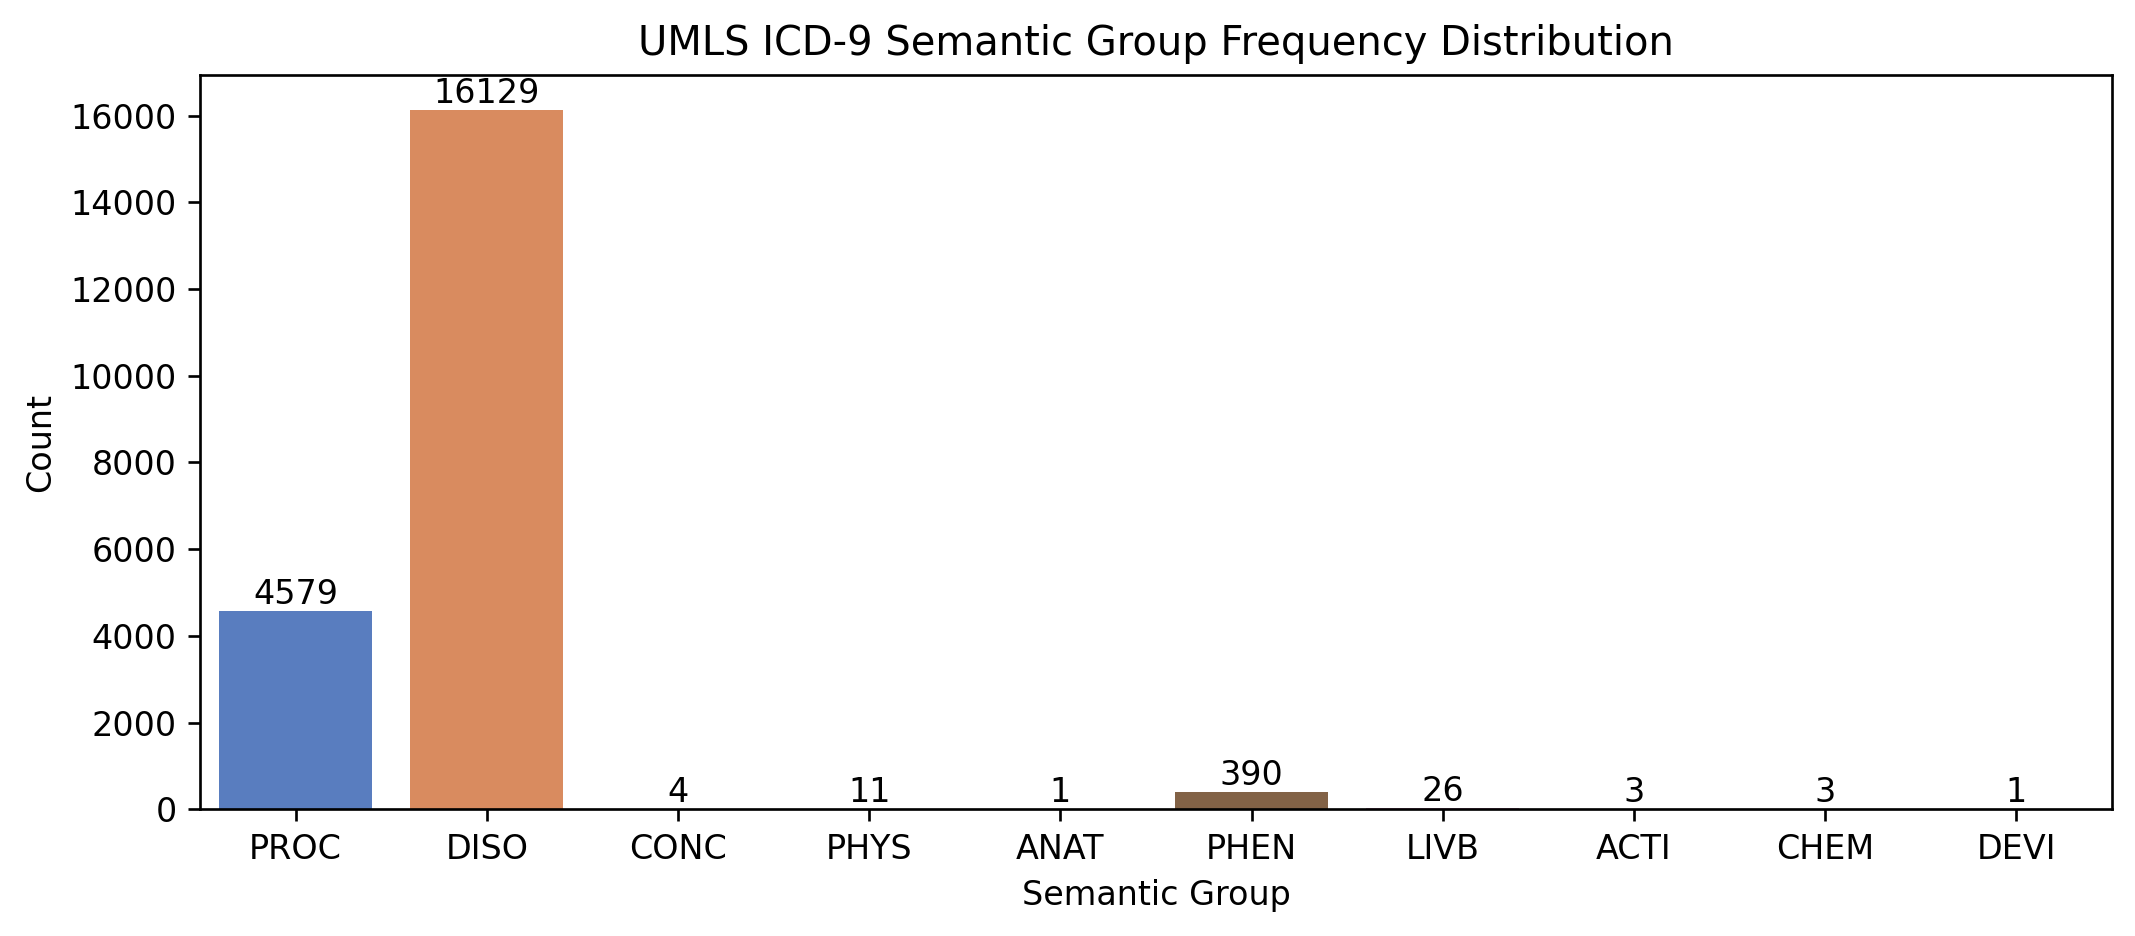

In [19]:
plt.figure(figsize=(9,4), dpi=240)
ax = sns.barplot(y=list(icd9_sg_counter.values()), x=list(icd9_sg_counter.keys()),palette="muted")
plt.xlabel(f"Semantic Group")
plt.ylabel(f"Count")
plt.title(f"UMLS ICD-9 Semantic Group Frequency Distribution")
plt.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

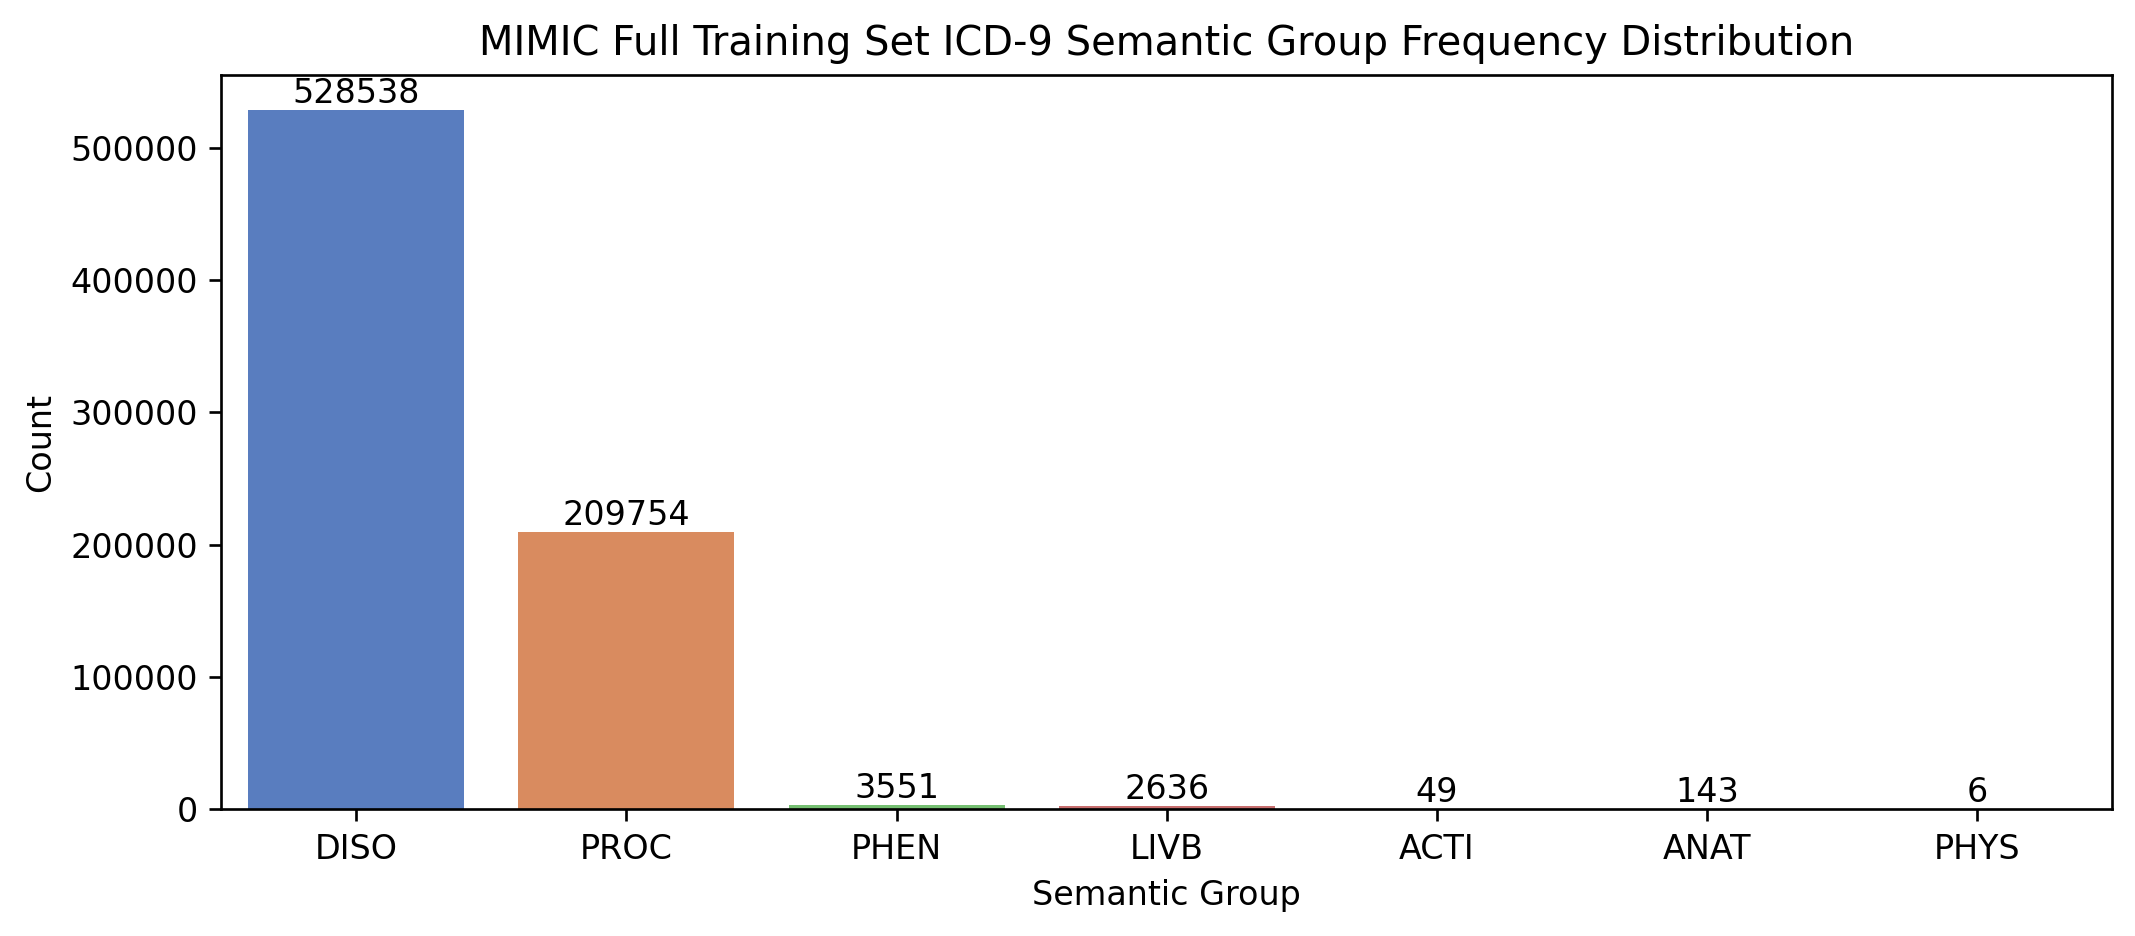

In [20]:
plt.figure(figsize=(9,4), dpi=240)
ax = sns.barplot(y=list(full_tr_sg.values()), x=list(full_tr_sg.keys()),palette="muted")
plt.xlabel(f"Semantic Group")
plt.ylabel(f"Count")
plt.title(f"MIMIC Full Training Set ICD-9 Semantic Group Frequency Distribution")
plt.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

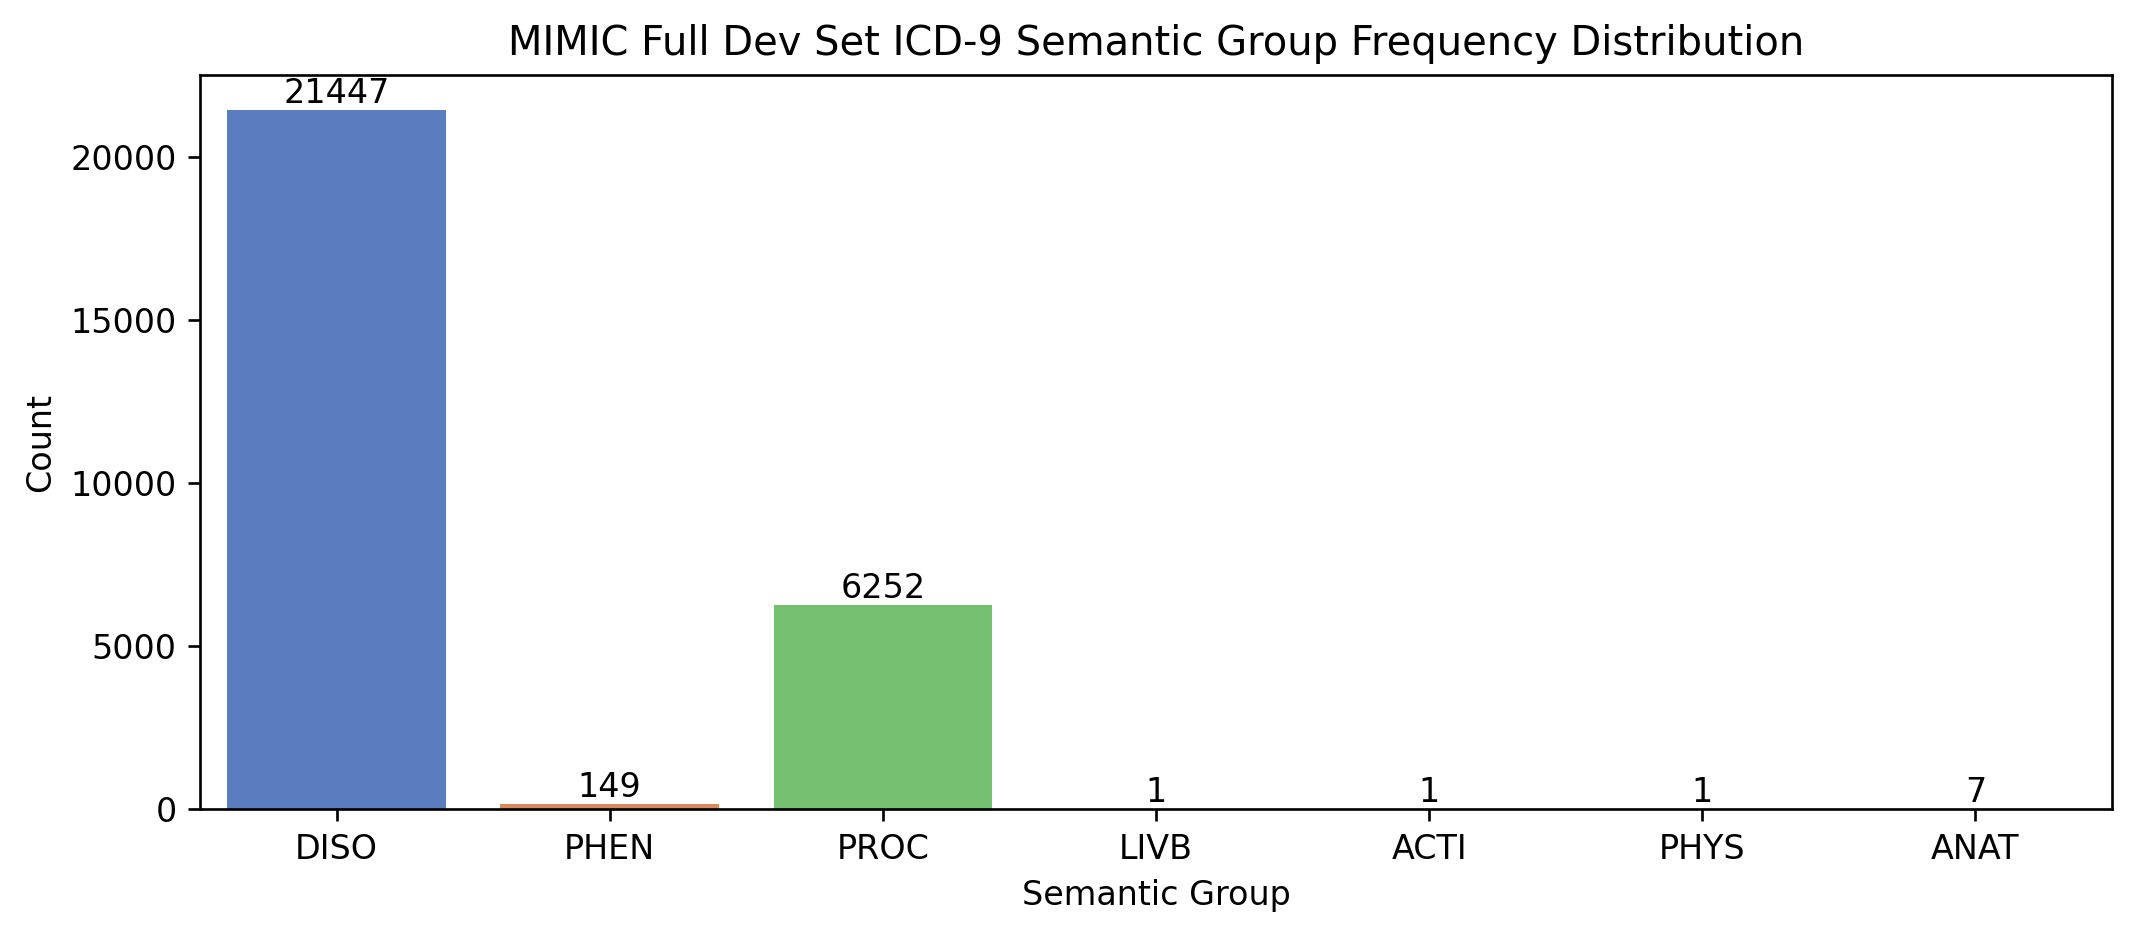

In [21]:
plt.figure(figsize=(9,4), dpi=240)
ax = sns.barplot(y=list(full_dev_sg.values()), x=list(full_dev_sg.keys()),palette="muted")
plt.xlabel(f"Semantic Group")
plt.ylabel(f"Count")
plt.title(f"MIMIC Full Dev Set ICD-9 Semantic Group Frequency Distribution")
plt.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

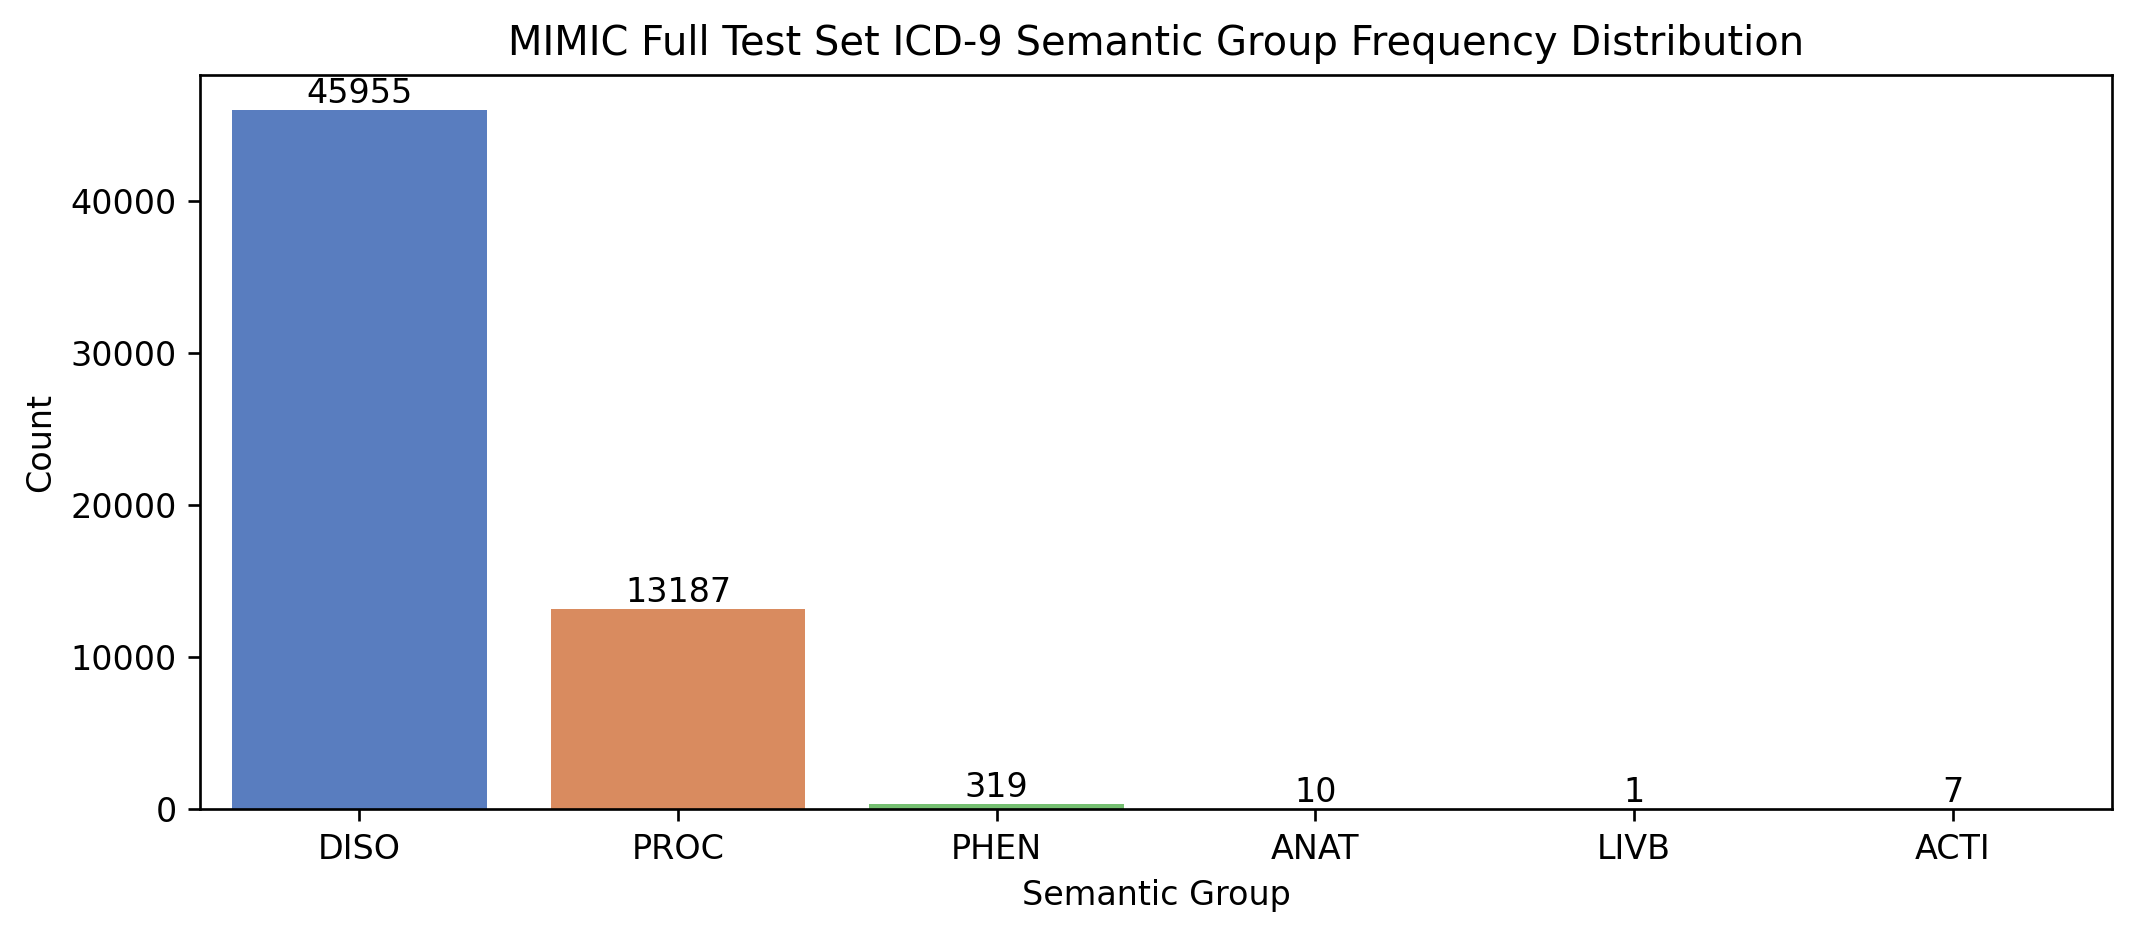

In [23]:
plt.figure(figsize=(9,4), dpi=240)
ax = sns.barplot(y=list(full_test_sg.values()), x=list(full_test_sg.keys()),palette="muted")
plt.xlabel(f"Semantic Group")
plt.ylabel(f"Count")
plt.title(f"MIMIC Full Test Set ICD-9 Semantic Group Frequency Distribution")
plt.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

In [31]:
# full (all partition distribution)
full_all_sg = dict()
temp_sg = mergeDictionary(full_tr_sg, full_dev_sg)
full_all_sg = mergeDictionary(temp_sg, full_test_sg)

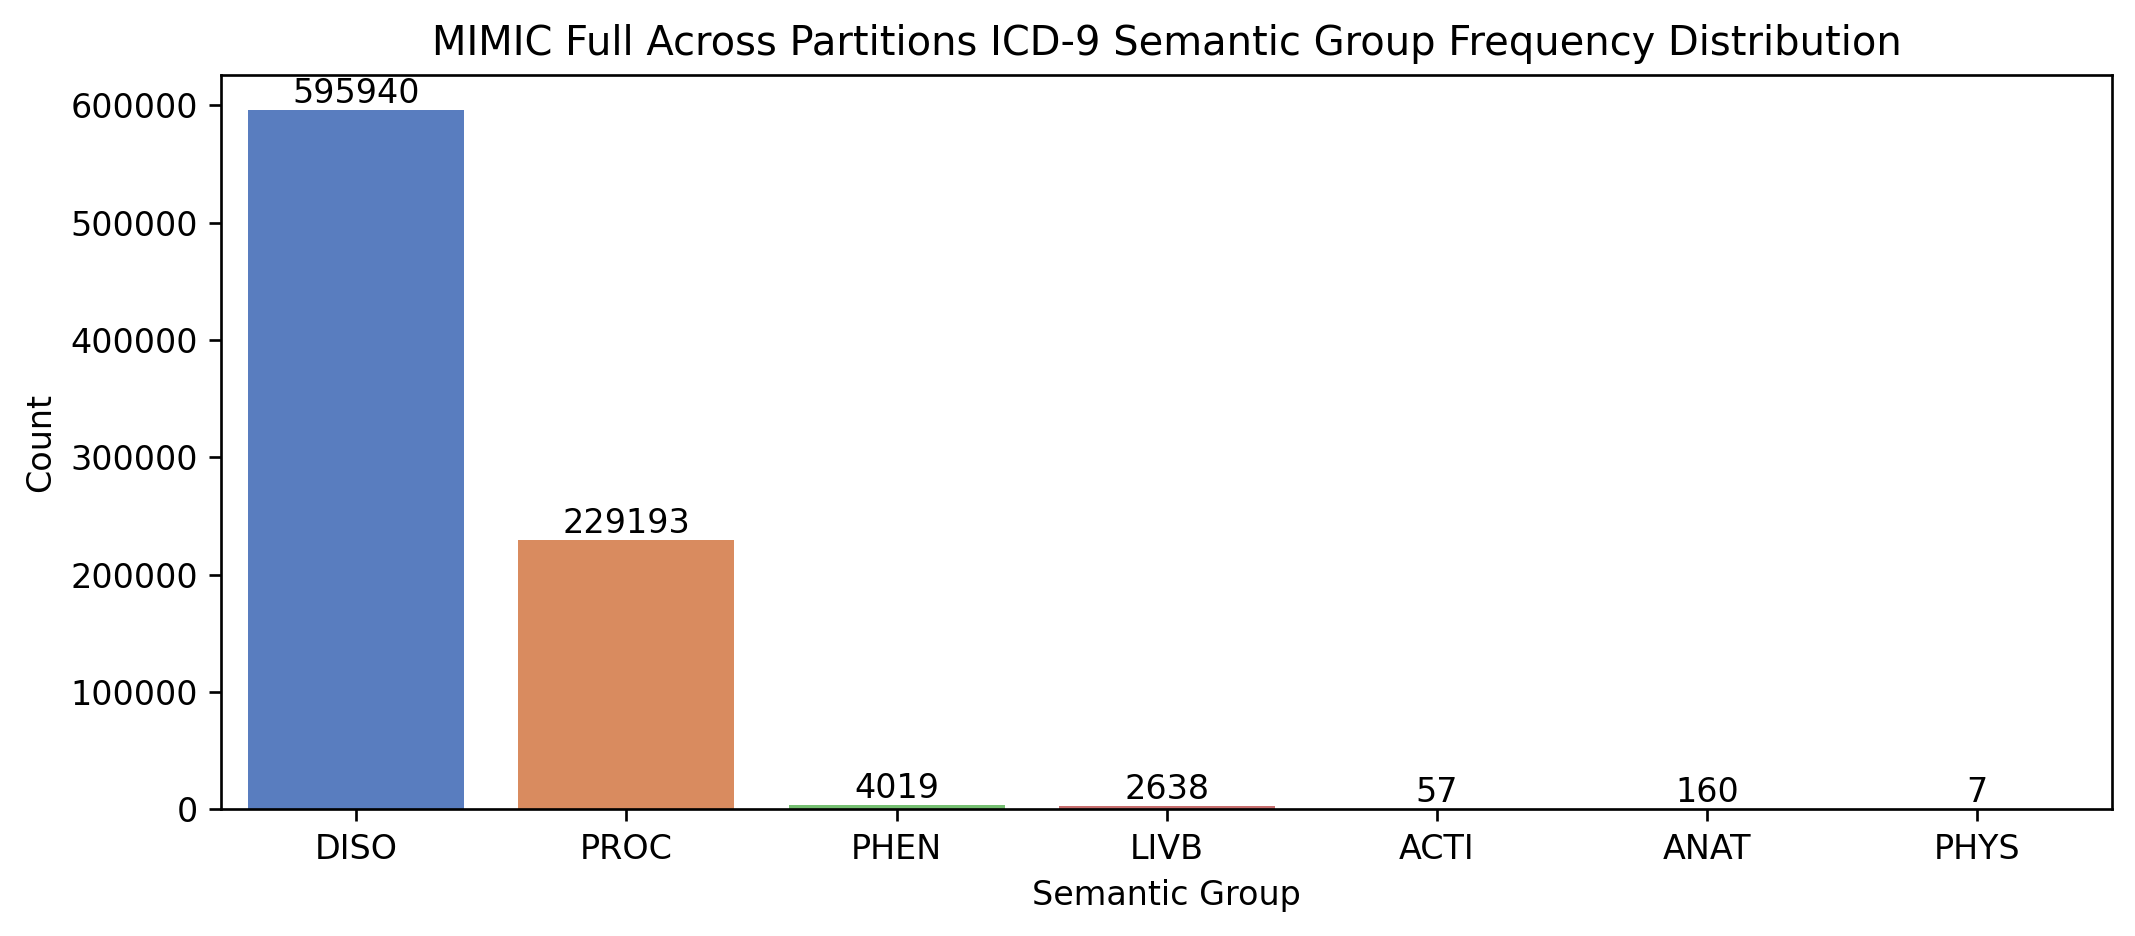

In [32]:
plt.figure(figsize=(9,4), dpi=240)
ax = sns.barplot(y=list(full_all_sg.values()), x=list(full_all_sg.keys()),palette="muted")
plt.xlabel(f"Semantic Group")
plt.ylabel(f"Count")
plt.title(f"MIMIC Full Across Partitions ICD-9 Semantic Group Frequency Distribution")
plt.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

In [ ]:
## MIMIC Dataset CUI Semantic Info Distribution

In [62]:
TOP50_CSV_FILE = f"{PROJ_FOLDER / 'data/mimic3/50/train_50.csv'}"
FULL_CSV_FILE = f"{PROJ_FOLDER / 'data/mimic3/full/train_full.csv'}"
TOP50_UMLS_FILE = f"{PROJ_FOLDER / 'data/linked_data/50/train_50_umls.txt'}"
FULL_UMLS_FILE = f"{PROJ_FOLDER / 'data/linked_data/full/train_full_full_umls.txt'}"
PRUNE_FILE_CASE4_50 = f"{PROJ_FOLDER / 'data/linked_data/50/50_cuis_to_discard_snomedcase4.pickle'}"
PRUNE_FILE_CASE4_FULL = f"{PROJ_FOLDER / 'data/linked_data/full/full_cuis_to_discard_snomedcase4.pickle'}"

In [42]:
def get_cui_sem_freq(cui_doc_iter, cui_to_sg_mapping, cui_to_tui_mapping, tui_to_sg_mapping):
    sem_group_counter = Counter()
    tui_counter = Counter()
    no_umls_coverage = Counter()
    
    for _, doc, _ in cui_doc_iter:
        for sent in doc:
            for cui in sent:
                sg = cui_to_sg_mapping.get(cui, '')
                tui = cui_to_tui_mapping.get(cui, '')
                if not sg:
                    sg = tui_to_sg_mapping.get(tui, '')
                    if not sg:
                        print(f"{cui} not in UMLS!!")
                        no_umls_coverage.update([cui])
                        continue
                sem_group_counter.update([sg])
                tui_counter.update([tui])
    
    return sem_group_counter, tui_counter, no_umls_coverage

In [39]:
top50_cui_docs = MimicCuiDocIter(TOP50_UMLS_FILE, 0.7, True, PRUNE_FILE_CASE4_50)

In [43]:
top50_sg_freq, top50_tui_freq, top50_no_coverage = get_cui_sem_freq(top50_cui_docs, 
                                                                    cui_to_sem_group, 
                                                                    cui_to_tui,
                                                                    sem_type_to_sem_group)

In [44]:
top50_sg_freq.most_common()

[('DISO', 1896573),
 ('PROC', 796788),
 ('CONC', 180420),
 ('DEVI', 99772),
 ('PHYS', 89032),
 ('ANAT', 72341),
 ('PHEN', 54354),
 ('CHEM', 2890),
 ('ACTI', 16),
 ('LIVB', 11)]

In [46]:
for tui, count in top50_tui_freq.most_common():
    print(f"{tui} - {tui_to_desc.get(tui, 'N/A')} - {sem_type_to_sem_group.get(tui, 'N/A')}: {count}")

T047 - Disease or Syndrome - DISO: 660126
T033 - Finding - DISO: 547953
T061 - Therapeutic or Preventive Procedure - PROC: 318185
T046 - Pathologic Function - DISO: 230876
T184 - Sign or Symptom - DISO: 218765
T059 - Laboratory Procedure - PROC: 182855
T058 - Health Care Activity - PROC: 177899
T169 - Functional Concept - CONC: 154314
T060 - Diagnostic Procedure - PROC: 115848
T074 - Medical Device - DEVI: 99772
T191 - Neoplastic Process - DISO: 73462
T031 - Body Substance - ANAT: 72341
T040 - Organism Function - PHYS: 67917
T048 - Mental or Behavioral Dysfunction - DISO: 56321
T037 - Injury or Poisoning - DISO: 49478
T019 - Congenital Abnormality - DISO: 30785
T034 - Laboratory or Test Result - PHEN: 30558
T078 - Idea or Concept - CONC: 26106
T032 - Organism Attribute - PHYS: 21115
T070 - Natural Phenomenon or Process - PHEN: 16859
T190 - Anatomical Abnormality - DISO: 16723
T020 - Acquired Abnormality - DISO: 12084
T067 - Phenomenon or Process - PHEN: 5791
T131 - Hazardous or Poisono

In [47]:
for tui, count in icd9_tui_counter.most_common():
    print(f"{tui} - {tui_to_desc.get(tui, 'N/A')} - {sem_type_to_sem_group.get(tui, 'N/A')}: {count}")

T047 - Disease or Syndrome - DISO: 6956
T037 - Injury or Poisoning - DISO: 3833
T061 - Therapeutic or Preventive Procedure - PROC: 3681
T033 - Finding - DISO: 1592
T191 - Neoplastic Process - DISO: 1061
T046 - Pathologic Function - DISO: 919
T060 - Diagnostic Procedure - PROC: 702
T048 - Mental or Behavioral Dysfunction - DISO: 586
T019 - Congenital Abnormality - DISO: 443
T020 - Acquired Abnormality - DISO: 294
T184 - Sign or Symptom - DISO: 275
T067 - Phenomenon or Process - PHEN: 262
T059 - Laboratory Procedure - PROC: 157
T190 - Anatomical Abnormality - DISO: 145
T068 - Human-caused Phenomenon or Process - PHEN: 115
T058 - Health Care Activity - PROC: 37
T101 - Patient or Disabled Group - LIVB: 24
T019,T047 - N/A - N/A: 18
T070 - Natural Phenomenon or Process - PHEN: 7
T032 - Organism Attribute - PHYS: 6
T040 - Organism Function - PHYS: 5
T038 - Biologic Function - PHEN: 4
T169 - Functional Concept - CONC: 3
T131 - Hazardous or Poisonous Substance - CHEM: 3
 - N/A - N/A: 3
T047,T19

In [48]:
for tui, count in icd9_tui_counter.most_common():
    if tui not in top50_tui_freq:
        print(f"{tui} {tui_to_desc.get(tui, 'N/A')} in icd9 labeset but not in input data")

T019,T047 N/A in icd9 labeset but not in input data
 N/A in icd9 labeset but not in input data
T047,T190 N/A in icd9 labeset but not in input data
T064 Governmental or Regulatory Activity in icd9 labeset but not in input data
T049 Cell or Molecular Dysfunction in icd9 labeset but not in input data


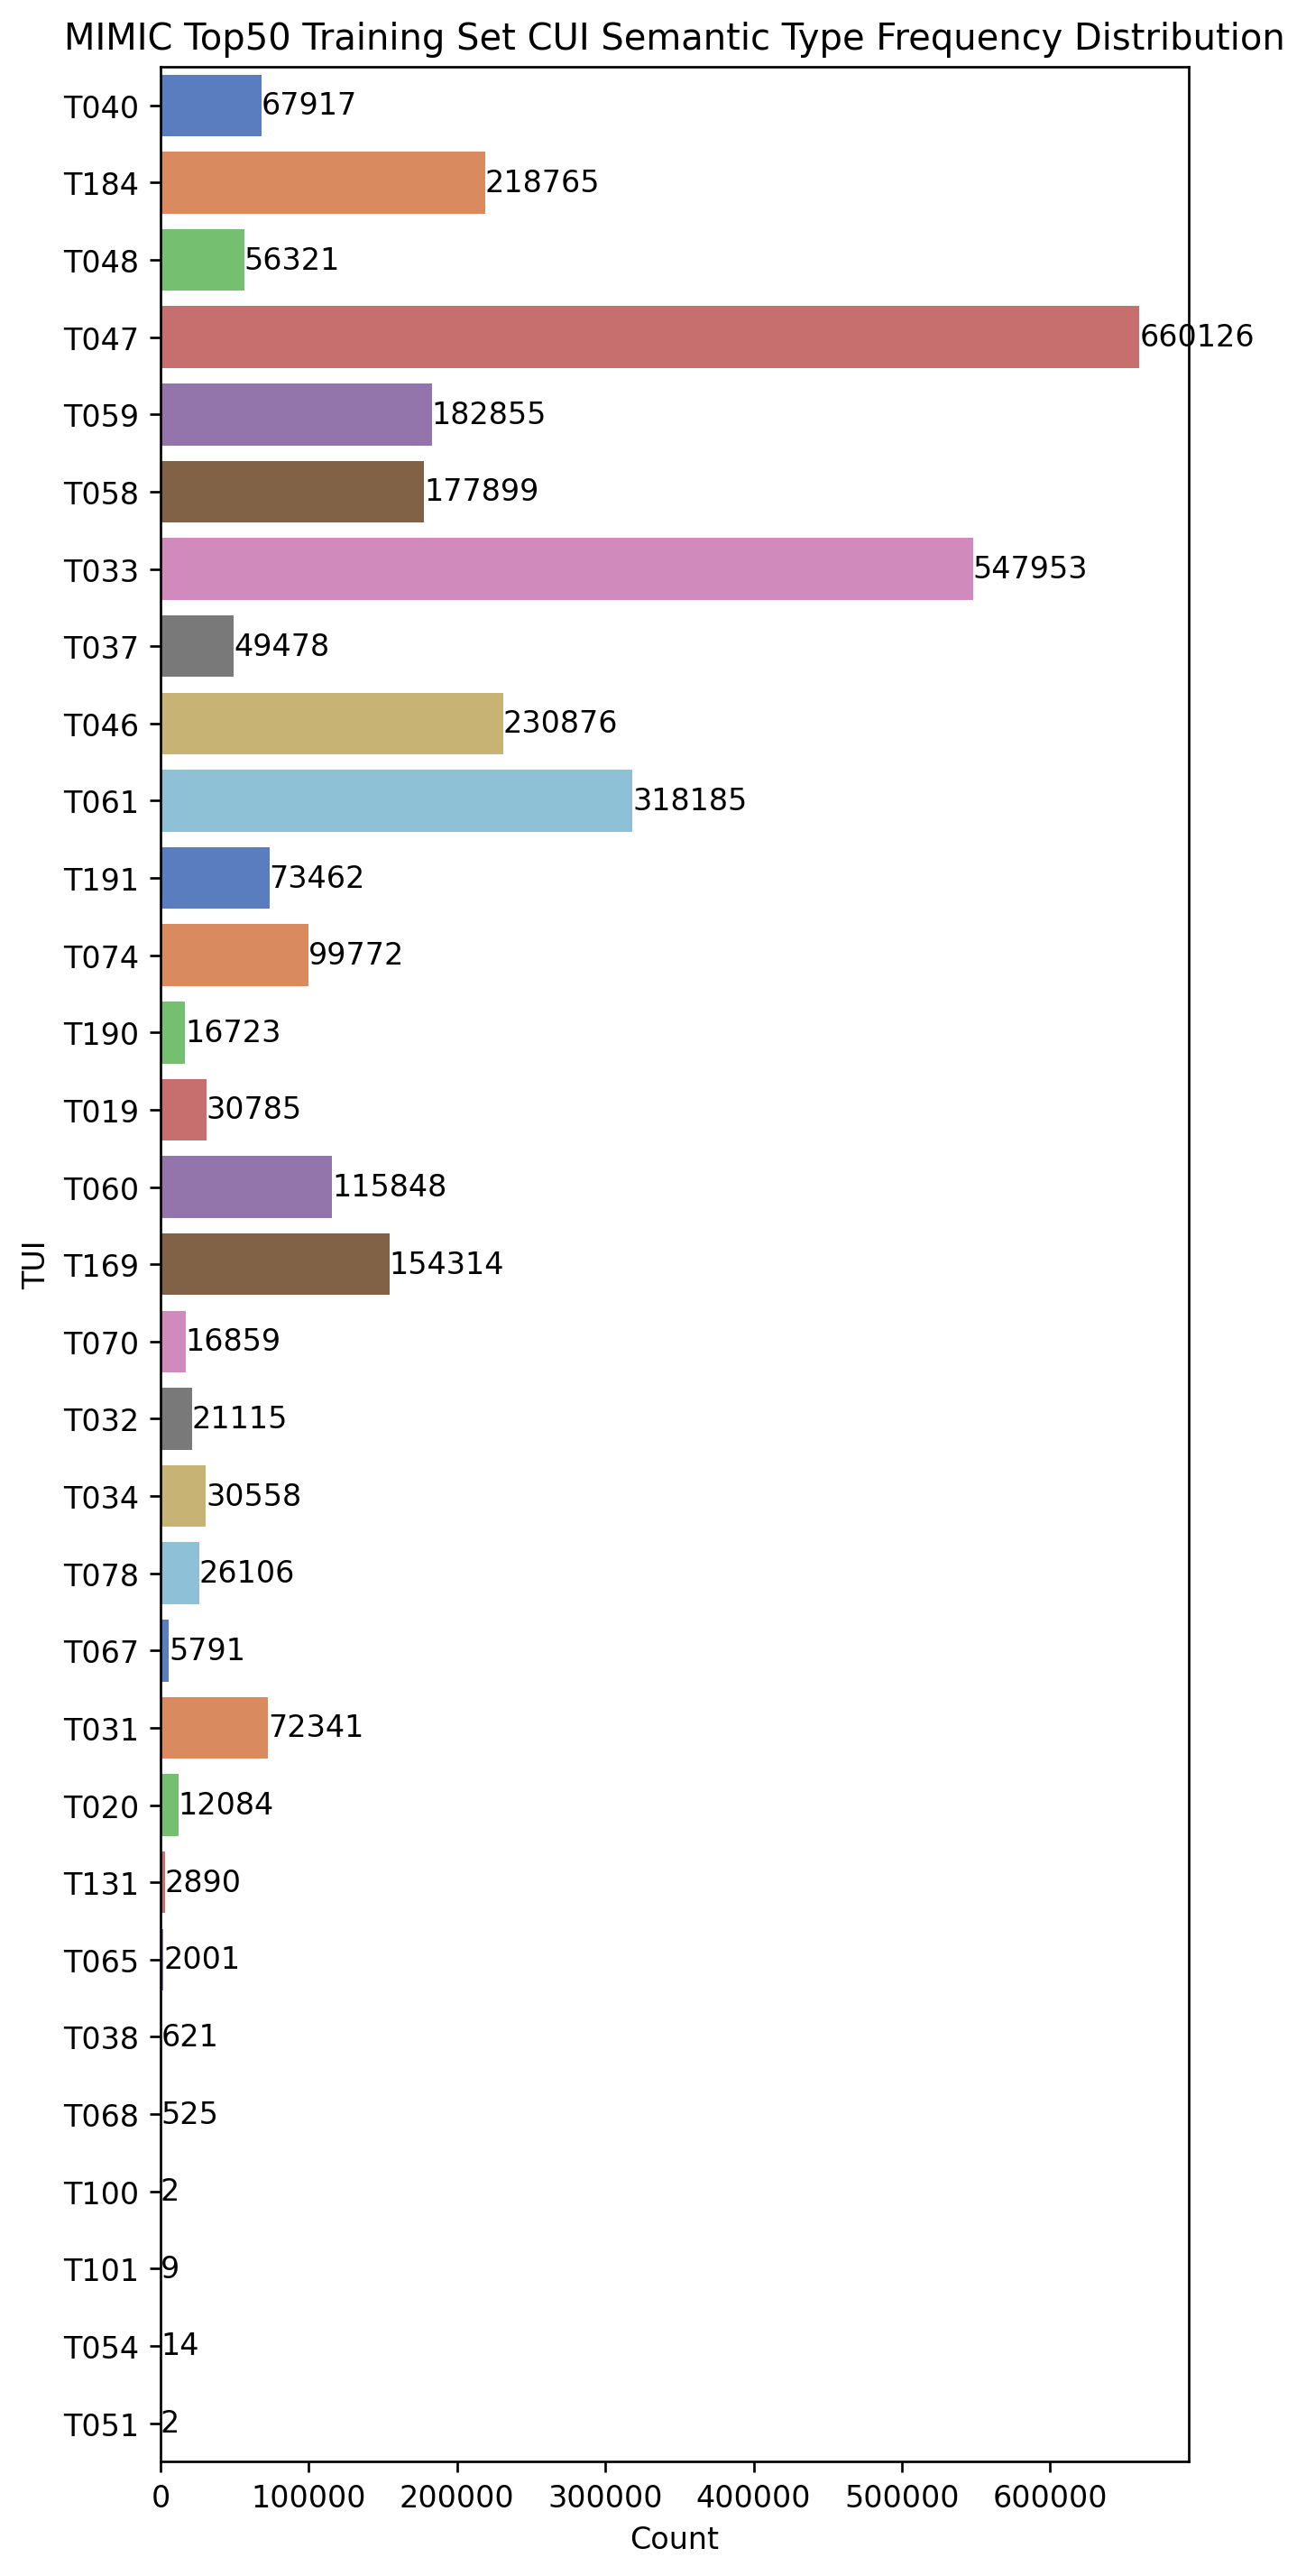

In [50]:
plt.figure(figsize=(6,12), dpi=240)
ax = sns.barplot(x=list(top50_tui_freq.values()), y=list(top50_tui_freq.keys()),palette="muted")
plt.ylabel(f"TUI")
plt.xlabel(f"Count")
plt.title(f"MIMIC Top50 Training Set CUI Semantic Type Frequency Distribution")
plt.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

In [63]:
full_cui_docs = MimicCuiDocIter(FULL_UMLS_FILE, 0.7, True, PRUNE_FILE_CASE4_FULL)

In [64]:
full_sg_freq, full_tui_freq, full_no_coverage = get_cui_sem_freq(full_cui_docs, 
                                                                 cui_to_sem_group, 
                                                                 cui_to_tui,
                                                                 sem_type_to_sem_group)

In [65]:
for tui, count in full_tui_freq.most_common():
    print(f"{tui} - {tui_to_desc.get(tui, 'N/A')} - {sem_type_to_sem_group.get(tui, 'N/A')}: {count}")

T047 - Disease or Syndrome - DISO: 3741172
T033 - Finding - DISO: 3166230
T061 - Therapeutic or Preventive Procedure - PROC: 1835408
T046 - Pathologic Function - DISO: 1317834
T184 - Sign or Symptom - DISO: 1274923
T059 - Laboratory Procedure - PROC: 1042738
T058 - Health Care Activity - PROC: 1032550
T169 - Functional Concept - CONC: 882112
T060 - Diagnostic Procedure - PROC: 669295
T074 - Medical Device - DEVI: 573324
T191 - Neoplastic Process - DISO: 415985
T031 - Body Substance - ANAT: 412039
T040 - Organism Function - PHYS: 404017
T048 - Mental or Behavioral Dysfunction - DISO: 321995
T037 - Injury or Poisoning - DISO: 300193
T019 - Congenital Abnormality - DISO: 180333
T034 - Laboratory or Test Result - PHEN: 176258
T078 - Idea or Concept - CONC: 148703
T032 - Organism Attribute - PHYS: 133802
T070 - Natural Phenomenon or Process - PHEN: 98695
T190 - Anatomical Abnormality - DISO: 93728
T020 - Acquired Abnormality - DISO: 68073
T067 - Phenomenon or Process - PHEN: 32688
T131 - Ha

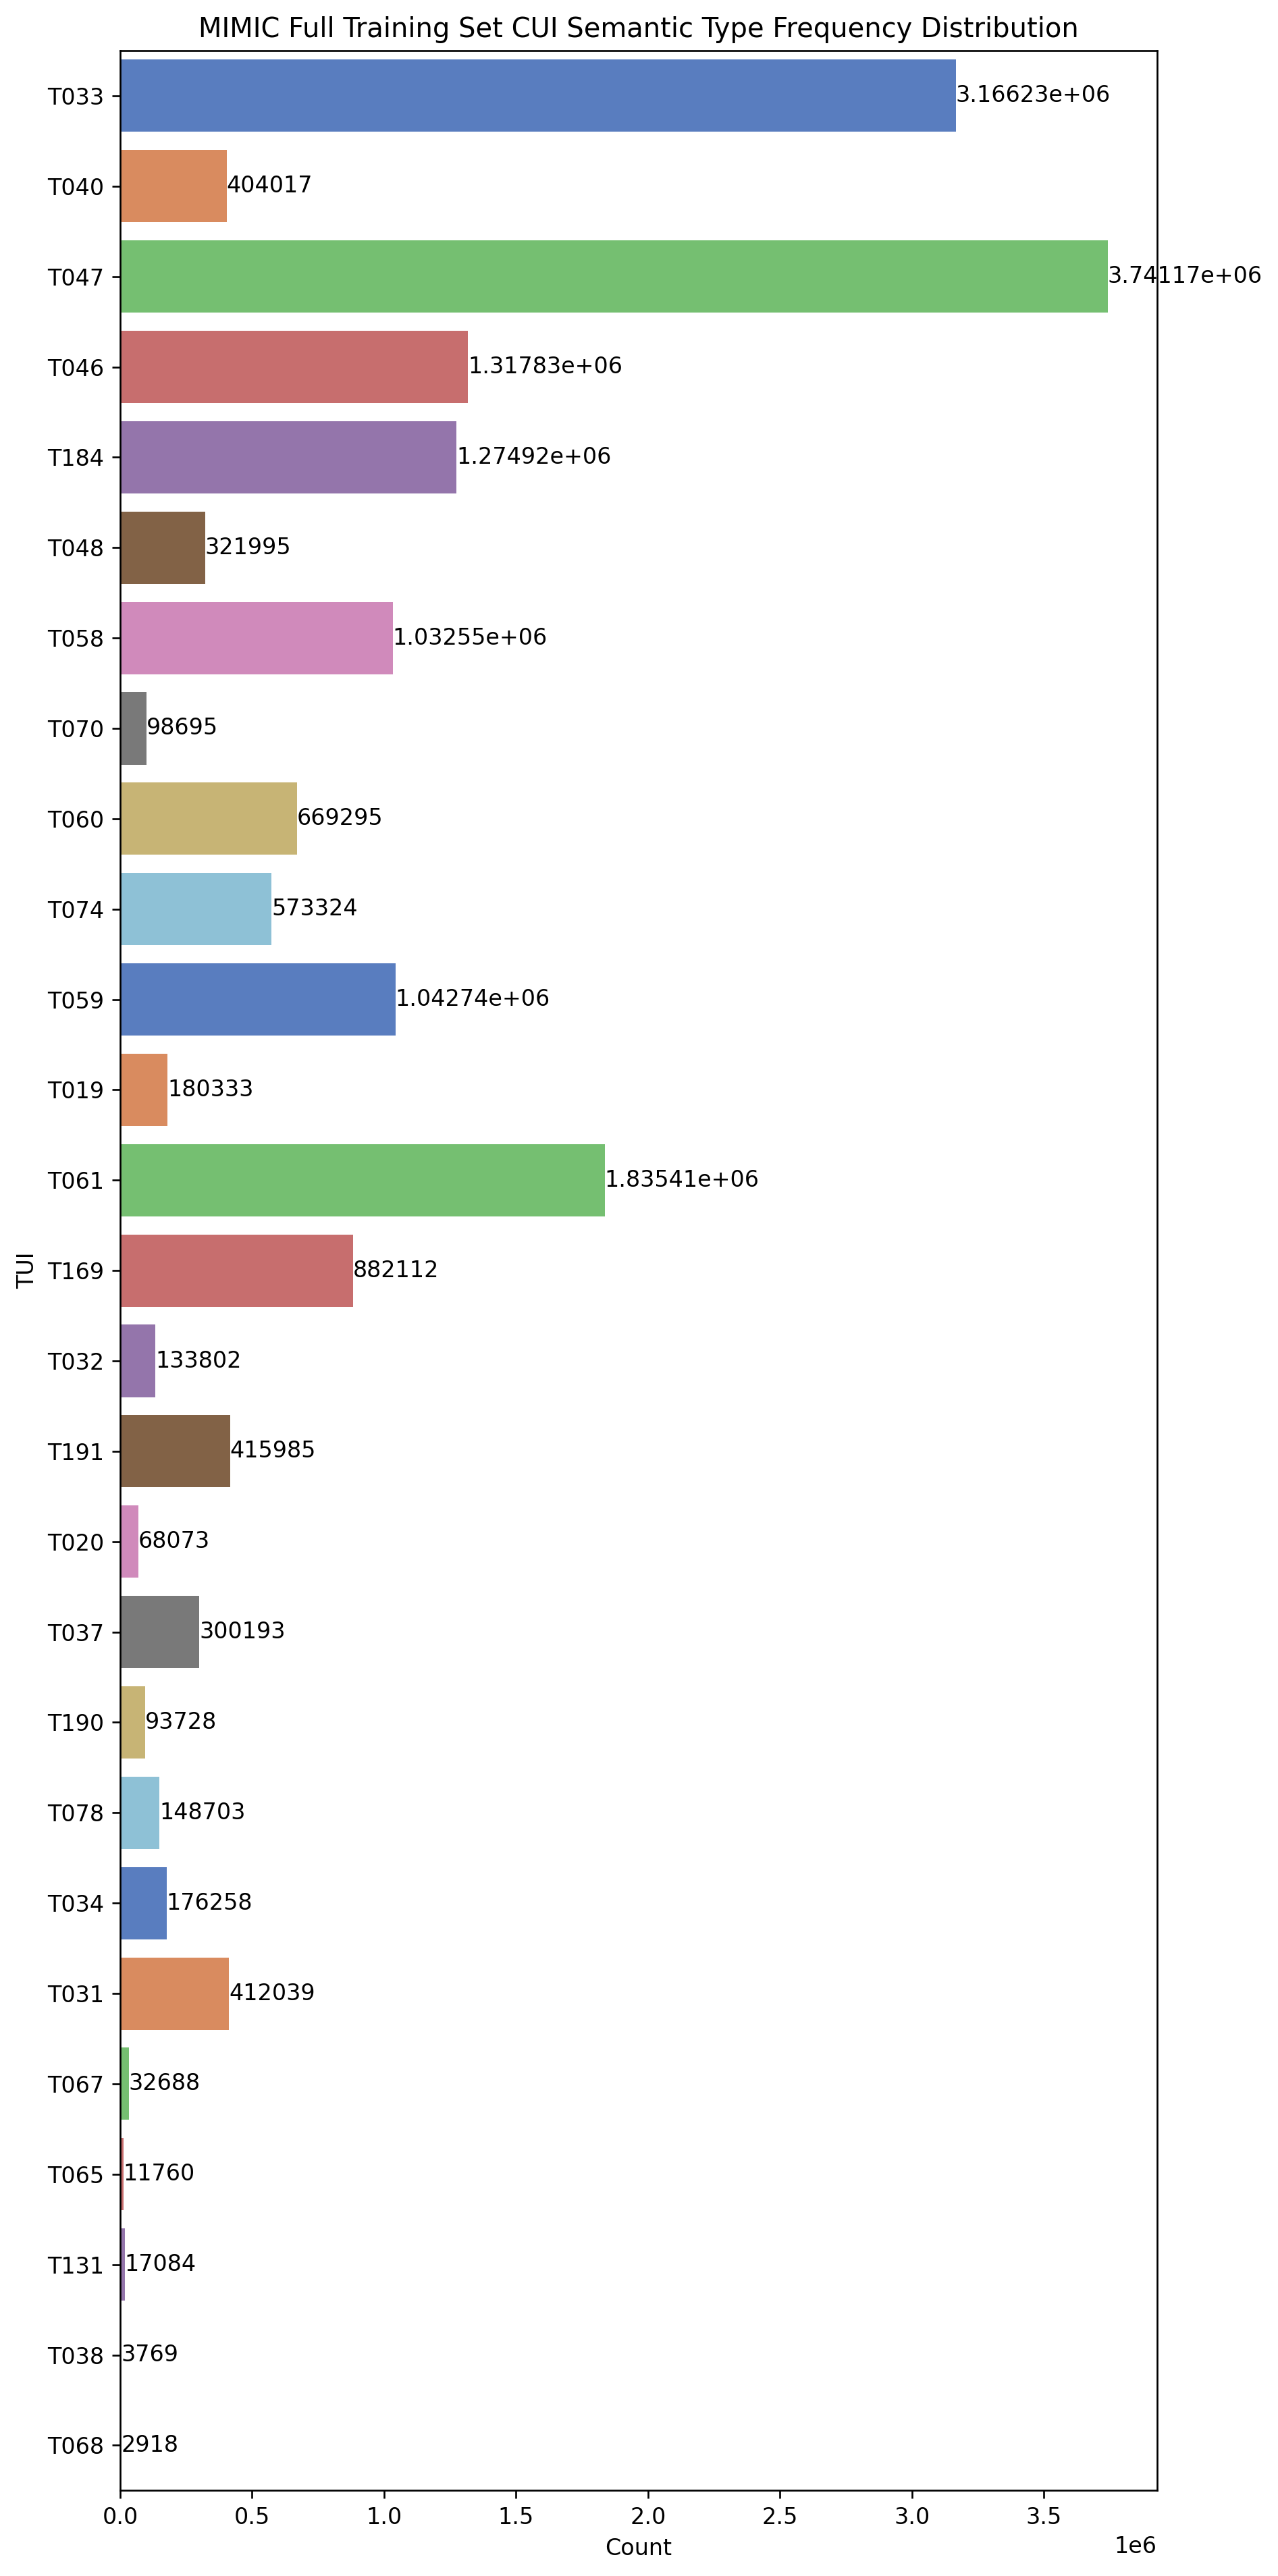

In [67]:
plt.figure(figsize=(8,16), dpi=240)
ax = sns.barplot(x=list(full_tui_freq.values()), y=list(full_tui_freq.keys()),palette="muted")
plt.ylabel(f"TUI")
plt.xlabel(f"Count")
plt.title(f"MIMIC Full Training Set CUI Semantic Type Frequency Distribution")
plt.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

In [72]:
len(full_tui_freq)

27

In [73]:
len(top50_tui_freq)

31

## Testing out Counting and Probability fo CUIs

All CUIs in with CONC SG go to conc  
DISO, ANAT, PHYS, PHEN (except T034, T059), LIVB  to dx  
T034, T059 (PHEN, PROC SG), CHEM sg go to labs  
PROC, DEVI, ACTI  SG to proc except T034, T059  

In [131]:
# unigram count by EHR structural component
unique_dx = Counter()
unique_proc = Counter()
unique_labs = Counter()
unique_conc = Counter()

In [127]:
# co-occurrence: (dx_i, proc_i), (proc_i,lab_i), (conc_i, dx_i), and (conc_i, proc)
dx_proc = Counter()
proc_lab = Counter()
conc_dx = Counter()
conc_proc = Counter()

In [ ]:
# P(Proc|Dx) == P(Proc, Dx)/P(Dx) == P(Dx, Proc)/P(Dx) == Count(Proc|Dx) / Count(Dx)
# P(Dx,Proc) == Count(Dx_i, Proc_i)/Count(all Dx_i)

#P(Dx) == Count(Dx_i)/Total Cui count

In [133]:
for _, doc, _ in top50_cui_docs:
    dx = set()
    proc = set()
    labs = set()
    concs = set()
    for sent in doc:
        for cui in sent:
            sg = cui_to_sem_group.get(cui, '')
            tui = cui_to_tui.get(cui, '')
            if sg in ['DISO', 'ANAT', 'PHYS', 'PHEN', 'LIVB'] and tui not in ['T034', 'T059']:
                unique_dx.update([cui])
                dx.update([cui])
            elif tui in ['T034', 'T059'] or sg in ['CHEM']:
                unique_labs.update([cui])
                labs.update([cui])
            elif sg in ['CONC']:
                unique_conc.update([cui])
                concs.update([cui])
            elif sg in ['PROC', 'DEVI', 'ACTI'] and tui not in ['T034','T059']:
                unique_proc.update([cui])
                proc.update([cui])
            else:
                print(f"unknown cui: {cui} sem info? {sg} -- {tui}")
    for dx_prx in itertools.product(dx, proc):
        dx_proc.update([dx_prx])
    for prx_lab in itertools.product(proc, labs):
        proc_lab.update([prx_lab])
    for c_dx in itertools.product(concs, dx):
        conc_dx.update([c_dx])
    for c_prx in itertools.product(concs, proc):
        conc_proc.update([c_prx])        

In [146]:
for d_idx, doc, _ in top50_cui_docs:
    unique_dx_1 = []
    unique_proc_1 = []
    unique_labs_1 = []
    unique_conc_1 = []
    for sent in doc:
        for cui in sent:
            sg = cui_to_sem_group.get(cui, '')
            tui = cui_to_tui.get(cui, '')
            if sg in ['DISO', 'ANAT', 'PHYS', 'PHEN', 'LIVB'] and tui not in ['T034', 'T059']:
                if cui not in unique_dx_1:
                    unique_dx_1.append(cui)
            elif tui in ['T034', 'T059'] or sg in ['CHEM']:
                if cui not in unique_labs_1:
                    unique_labs_1.append(cui)
            elif sg in ['CONC']:
                if cui not in unique_conc_1:
                    unique_conc_1.append(cui)
            elif sg in ['PROC', 'DEVI', 'ACTI'] and tui not in ['T034','T059']:
                if cui not in unique_proc_1:
                    unique_proc_1.append(cui)
            else:
                print(f"unknown cui: {cui} sem info? {sg} -- {tui}")
    if (len(unique_conc_1) > 0 or len(unique_labs_1) > 0) and d_idx == 5:
        print(d_idx)
        break

5


In [148]:
for tup in itertools.product(unique_proc_1, unique_labs_1, repeat=1):
    c1, c2 = tup
    try:
        p_lab_proc = float(proc_lab.get(tup, '0'))/float(unique_proc.get(c1, '0'))
    except ZeroDivisionError:
        p_lab_proc = float(0)
    print(f"P({c2}|{c1}): {p_lab_proc}")

P(C2698261|C0021925): 0.06369731800766283
P(C2698261|C0040405): 0.11451863354037267
P(C2698261|C3472245): 0.13764880952380953
P(C2698261|C1699633): 0.13549752999294284
P(C2698261|C0034606): 0.12807109252483012
P(C2698261|C0553891): 0.07433405327573794
P(C2698261|C0030704): 0.12784265519360788
P(C2698261|C0150521): 0.28779979144942647
P(C2698261|C0184573): 0.14377959535083942
P(C2698261|C0150192): 0.140993265993266
P(C2698261|C0030231): 0.24087591240875914
P(C2698261|C0011900): 0.10093209054593875
P(C2698261|C0002928): 0.07450523864959255


In [149]:
for tup in itertools.product(unique_conc_1, unique_dx_1, repeat=1):
    c1, c2 = tup
    try:
        p_dx_conc = float(conc_dx.get(tup, '0'))/float(unique_conc.get(c1, '0'))
    except ZeroDivisionError:
        p_dx_conc = float(0)
    print(f"P({c2}|{c1}): {p_dx_conc}")

P(C0151699|C0442808): 0.0528169014084507
P(C0019080|C0442808): 0.32922535211267606
P(C0036572|C0442808): 0.14568661971830985
P(C0751495|C0442808): 0.15272887323943662
P(C0270844|C0442808): 0.13908450704225353
P(C0221106|C0442808): 0.7337147887323944
P(C0178415|C0442808): 0.7337147887323944
P(C0020459|C0442808): 0.7337147887323944
P(C0455769|C0442808): 0.7337147887323944
P(C0423908|C0442808): 0.09154929577464789
P(C0009763|C0442808): 0.023767605633802816
P(C1260880|C0442808): 0.2007042253521127
P(C0586514|C0442808): 0.06338028169014084
P(C0029163|C0442808): 0.24955985915492956
P(C0426747|C0442808): 0.26188380281690143
P(C0475072|C0442808): 0.020246478873239437
P(C3698285|C0442808): 0.01232394366197183
P(C2937358|C0442808): 0.02596830985915493
P(C0026850|C0442808): 0.2909330985915493
P(C0242271|C0442808): 0.19234154929577466
P(C0151699|C1879489): 0.07125603864734299
P(C0019080|C1879489): 0.3961352657004831
P(C0036572|C1879489): 0.15096618357487923
P(C0751495|C1879489): 0.1449275362318840

In [150]:
for tup in itertools.product(unique_conc_1, unique_proc_1, repeat=1):
    c1, c2 = tup
    try:
        p_proc_conc = float(conc_proc.get(tup, '0'))/float(unique_conc.get(c1, '0'))
    except ZeroDivisionError:
        p_proc_conc = float(0)
    print(f"P({c2}|{c1}): {p_proc_conc}")

P(C0021925|C0442808): 0.32130281690140844
P(C0040405|C0442808): 0.18705985915492956
P(C3472245|C0442808): 0.10871478873239436
P(C1699633|C0442808): 0.11399647887323944
P(C0034606|C0442808): 0.15184859154929578
P(C0553891|C0442808): 0.3221830985915493
P(C0030704|C0442808): 0.24691901408450703
P(C0150521|C0442808): 0.06690140845070422
P(C0184573|C0442808): 0.18882042253521128
P(C0150192|C0442808): 0.18882042253521128
P(C0030231|C0442808): 0.08054577464788733
P(C0011900|C0442808): 0.42561619718309857
P(C0002928|C0442808): 0.061619718309859156
P(C0021925|C1879489): 0.3828502415458937
P(C0040405|C1879489): 0.21980676328502416
P(C3472245|C1879489): 0.13043478260869565
P(C1699633|C1879489): 0.14130434782608695
P(C0034606|C1879489): 0.1859903381642512
P(C0553891|C1879489): 0.2995169082125604
P(C0030704|C1879489): 0.2524154589371981
P(C0150521|C1879489): 0.2693236714975845
P(C0184573|C1879489): 0.23792270531400966
P(C0150192|C1879489): 0.22946859903381642
P(C0030231|C1879489): 0.276570048309178

In [151]:
for tup in itertools.product(unique_dx_1, unique_proc_1, repeat=1):
    c1, c2 = tup
    try:
        p_proc_dx = float(dx_proc.get(tup, '0'))/float(unique_dx.get(c1, '0'))
    except ZeroDivisionError:
        p_proc_dx = float(0)
    print(f"P({c2}|{c1}): {p_proc_dx}")

P(C0021925|C0151699): 0.401854714064915
P(C0040405|C0151699): 0.23647604327666152
P(C3472245|C0151699): 0.1391035548686244
P(C1699633|C0151699): 0.14837712519319937
P(C0034606|C0151699): 0.18238021638330756
P(C0553891|C0151699): 0.3462132921174652
P(C0030704|C0151699): 0.2596599690880989
P(C0150521|C0151699): 0.07264296754250386
P(C0184573|C0151699): 0.18547140649149924
P(C0150192|C0151699): 0.18083462132921174
P(C0030231|C0151699): 0.08809891808346214
P(C0011900|C0151699): 0.4327666151468315
P(C0002928|C0151699): 0.1437403400309119
P(C0021925|C0019080): 0.13698495427278984
P(C0040405|C0019080): 0.08329235913069132
P(C3472245|C0019080): 0.05084079063821418
P(C1699633|C0019080): 0.052414200019667616
P(C0034606|C0019080): 0.06736158914347527
P(C0553891|C0019080): 0.11761235126364442
P(C0030704|C0019080): 0.10384501917592684
P(C0150521|C0019080): 0.028124692693480186
P(C0184573|C0019080): 0.07670370734585505
P(C0150192|C0019080): 0.07660536925951421
P(C0030231|C0019080): 0.035205034910020

In [141]:
for tup in itertools.product(unique_dx_1, unique_proc_1, repeat=1):
    c1, c2 = tup
    try:
        p_dx_proc = float(dx_proc.get(tup, '0'))/float(unique_proc.get(c2, '0'))
    except ZeroDivisionError:
        p_dx_proc = float(0)
    print(f"P({c1}|{c2}): {p_dx_proc}")

P(C0001779|C0199168): 0.1815967016491754
P(C0001779|C0587569): 0.18073763328089495
P(C0001779|C0010337): 0.14728682170542637
P(C0001779|C0002766): 0.21455457967377667
P(C0001779|C0150270): 0.1290592567793773
P(C0001779|C0557061): 0.2651006711409396
P(C0001779|C0185117): 0.2826086956521739
P(C0001779|C0033325): 0.1991701244813278
P(C0001779|C0150521): 0.18143899895724713
P(C0086582|C0199168): 0.33901799100449775
P(C0086582|C0587569): 0.32616675406397483
P(C0086582|C0010337): 0.20381136950904394
P(C0086582|C0002766): 0.2710163111668758
P(C0086582|C0150270): 0.16170070304653497
P(C0086582|C0557061): 0.2930648769574944
P(C0086582|C0185117): 0.30570652173913043
P(C0086582|C0033325): 0.2925311203319502
P(C0086582|C0150521): 0.1908237747653806
P(C0004238|C0199168): 0.18478260869565216
P(C0004238|C0587569): 0.1802132494319175
P(C0004238|C0010337): 0.12306201550387597
P(C0004238|C0002766): 0.22040987034713508
P(C0004238|C0150270): 0.1049548041513224
P(C0004238|C0557061): 0.2348993288590604
P(C0

In [152]:
for tup in itertools.product(unique_proc_1, repeat=2):
    c1, c2 = tup
    if cui_to_tui.get(c1) == cui_to_tui.get(c2):
        tui = cui_to_tui.get(c1)
        print(c1, c2, tui, tui_to_desc.get(tui))

C0021925 C0021925 T061 Therapeutic or Preventive Procedure
C0021925 C0553891 T061 Therapeutic or Preventive Procedure
C0021925 C0184573 T061 Therapeutic or Preventive Procedure
C0021925 C0030231 T061 Therapeutic or Preventive Procedure
C0021925 C0002928 T061 Therapeutic or Preventive Procedure
C0040405 C0040405 T060 Diagnostic Procedure
C0040405 C3472245 T060 Diagnostic Procedure
C0040405 C1699633 T060 Diagnostic Procedure
C0040405 C0034606 T060 Diagnostic Procedure
C0040405 C0011900 T060 Diagnostic Procedure
C3472245 C0040405 T060 Diagnostic Procedure
C3472245 C3472245 T060 Diagnostic Procedure
C3472245 C1699633 T060 Diagnostic Procedure
C3472245 C0034606 T060 Diagnostic Procedure
C3472245 C0011900 T060 Diagnostic Procedure
C1699633 C0040405 T060 Diagnostic Procedure
C1699633 C3472245 T060 Diagnostic Procedure
C1699633 C1699633 T060 Diagnostic Procedure
C1699633 C0034606 T060 Diagnostic Procedure
C1699633 C0011900 T060 Diagnostic Procedure
C0034606 C0040405 T060 Diagnostic Procedure
C

it seems TUI-TUI connections are similar to KG relations, which may explain why results from both types of graph construction
seem to be fairly similar.


In [224]:
data_reader = GNNDataReader(data_dir=f"{PROJ_FOLDER / 'data' / 'mimic3'}",
                                    version="dummy",
                                    input_type="umls",
                                    prune_cui=True,
                                    cui_prune_file="full_cuis_to_discard_snomedcase4.pickle",
                                    vocab_fn="processed_full_umls_pruned.json")
gnn_dataset = GNNDataset(dataset=data_reader.get_dataset("train"),
                         mlb=data_reader.mlb,
                         name="train",
                         mode="combined_tui_kg_rel",
                         force_reload=False,
                         verbose=True)
        

Done loading data from cached files.


In [225]:
num_samples = len(gnn_dataset)
g_sample, label_sample, gnidx_sample = gnn_dataset[num_samples - 1]
print("doc_id", gnn_dataset.data[num_samples - 1][0])
print(g_sample)
print(gnn_dataset.cc_dict[num_samples - 1])
print(gnidx_sample)

doc_id 16525_134157
Graph(num_nodes=38, num_edges=184,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.float32), 'attr': Scheme(shape=(100,), dtype=torch.float32)}
      edata_schemes={})
[{0, 37, 31}, {1, 7, 8, 9, 22}, {32, 2, 24, 27, 30}, {34, 3, 4, 36, 15, 16, 17}, {33, 5, 12, 18, 19}, {28, 6}, {10, 13, 21, 23, 25}, {35, 11, 14, 20, 26, 29}]
{0: 'C0150521', 1: 'C0348011', 2: 'C0242271', 3: 'C0151699', 4: 'C3698285', 5: 'C0021925', 6: 'C0036572', 7: 'C0442808', 8: 'C0242485', 9: 'C1879489', 10: 'C0034606', 11: 'C0221106', 12: 'C0002928', 13: 'C1699633', 14: 'C0020459', 15: 'C2937358', 16: 'C0019080', 17: 'C0426747', 18: 'C0030231', 19: 'C0184573', 20: 'C0009763', 21: 'C0040405', 22: 'C2698261', 23: 'C0011900', 24: 'C0586514', 25: 'C3472245', 26: 'C0026850', 27: 'C0178415', 28: 'C1260880', 29: 'C0751495', 30: 'C0423908', 31: 'C0030704', 32: 'C0455769', 33: 'C0553891', 34: 'C0029163', 35: 'C0270844', 36: 'C0475072', 37: 'C0150192'}


In [171]:
#network x options
options = {
    'node_color': 'blue',
    'node_size': 100,
    'width': 0.75,
    'arrowsize': 6
}

In [167]:
import matplotlib.pyplot as plt
import networkx as nx

In [232]:
options = {"edgecolors": "tab:gray", "node_size": 300, "alpha": 0.9, 'arrowsize': 200}

In [226]:
edge_list = list(zip(g_sample.edges()[0].tolist(), g_sample.edges()[1].tolist()))
nx_g_kg_combo = nx.from_edgelist(edge_list)

In [234]:
pos_kg_c = nx.spring_layout(nx_g_kg_combo, k=0.65, iterations=30, seed=3113794652)

In [234]:
pos_kg_c = nx.spring_layout(nx_g_kg_combo, k=0.65, iterations=30, seed=3113794652)

In [234]:
pos_kg_c = nx.spring_layout(nx_g_kg_combo, k=0.65, iterations=30, seed=3113794652)

{0: Text(-0.2924648250143503, 0.8405596909529429, 'C0029163'),
 1: Text(0.822240700406409, -0.19605309664169024, 'C0455769'),
 2: Text(-0.3845815397827092, 0.755095365820498, 'C0426747'),
 3: Text(-0.7843115206683494, -0.2808414423088254, 'C0221106'),
 4: Text(-0.6977063327223135, -0.18709754662707362, 'C0751495'),
 5: Text(-0.7321597012420052, 0.487307999362261, 'C0034606'),
 6: Text(-0.5486002169677741, -0.2969576681809296, 'C0026850'),
 7: Text(-0.5491639466507772, -0.09122821571386167, 'C0020459'),
 8: Text(0.2701619110691906, 0.2456800221927818, 'C0348011'),
 9: Text(0.46811426634364467, 0.8208972776577971, 'C2698261'),
 10: Text(-0.4296216820167389, 0.4254308351307037, 'C0019080'),
 11: Text(0.40973126291076606, -0.8418998046613616, 'C0150192'),
 12: Text(-0.4327985516307505, 0.8786390686824852, 'C3698285'),
 13: Text(0.4614545393202654, -0.50607954659143, 'C0150521'),
 14: Text(1.0, -0.1929333908480564, 'C0475072'),
 15: Text(0.12355711406592544, 0.298569732967622, 'C1879489'),


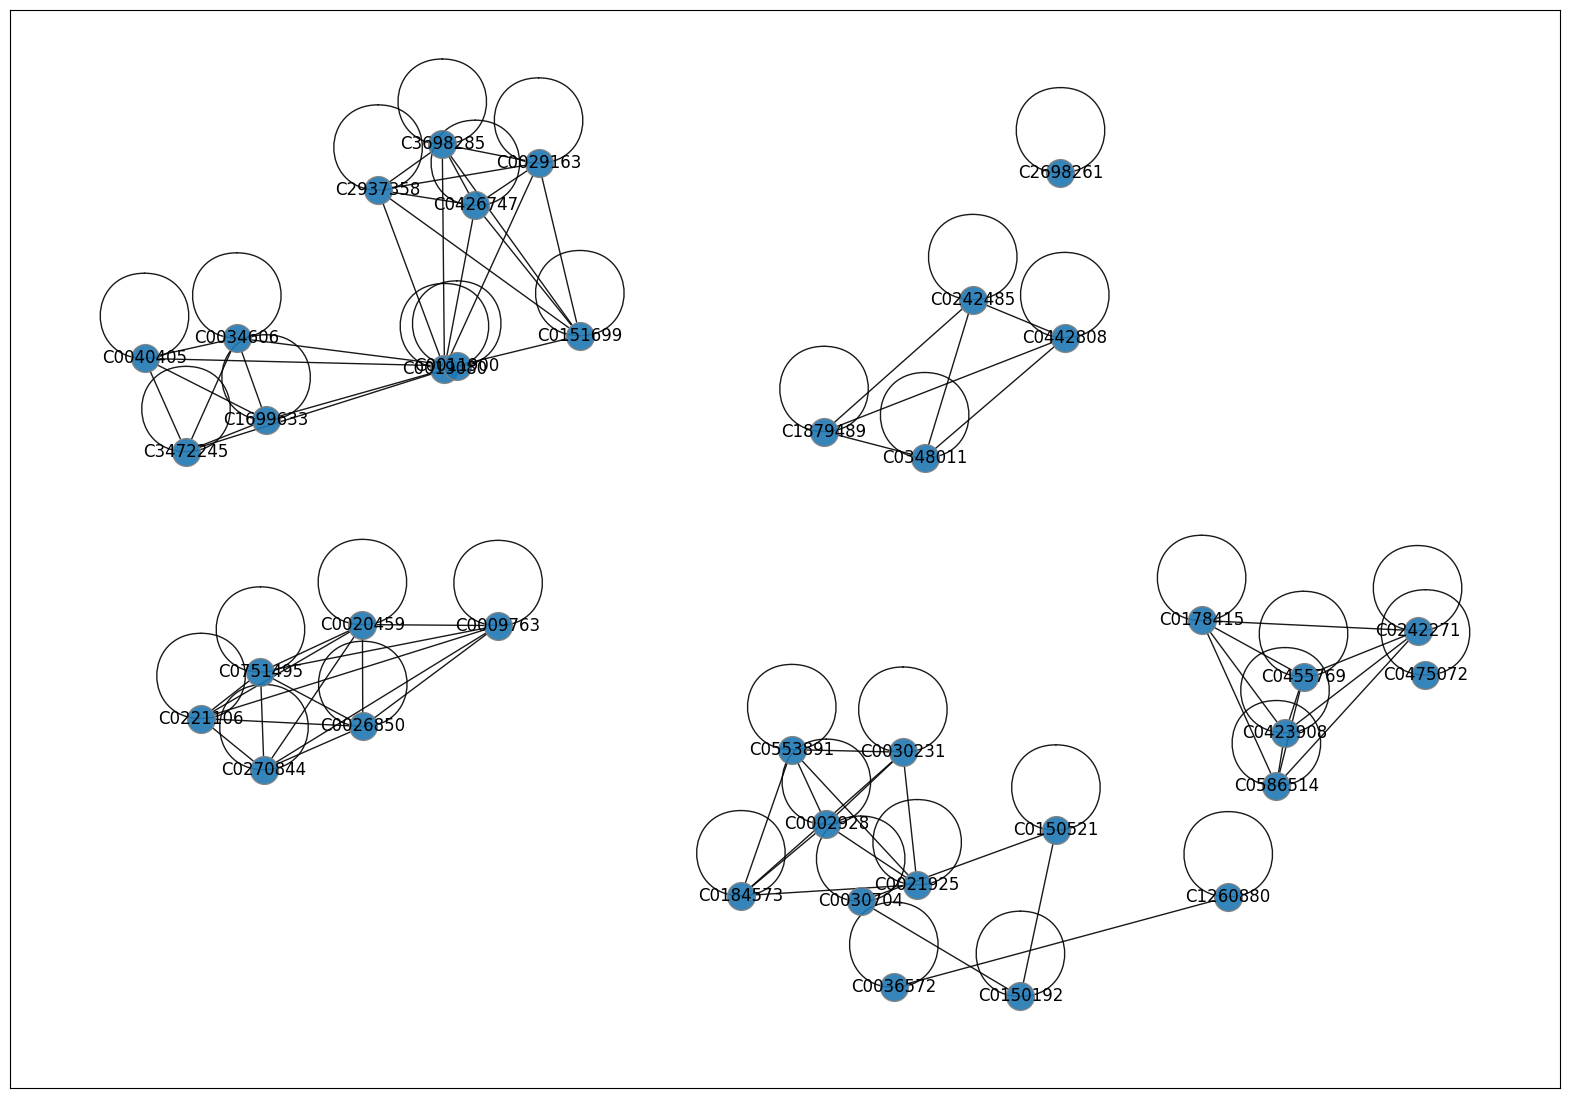

In [214]:
plt.figure(figsize=[20,14])
plt.tight_layout()
nx.draw_networkx(nx_g, pos=pos, arrows=True, with_labels=False, **options)
nx.draw_networkx_labels(nx_g, pos, gnidx_sample, font_size=12)

{0: Text(-0.1717512287363369, 0.8823455813372263, 'C1699633'),
 1: Text(-0.5667571008214908, -0.8308396060365432, 'C0026850'),
 2: Text(-0.5559533866717364, 0.8833140631697747, 'C0242485'),
 3: Text(-0.20266514384871454, -0.8835377874778093, 'C0553891'),
 4: Text(0.5992701684080258, -0.6793011012220496, 'C0034606'),
 5: Text(-0.21669181574894913, 0.9186464979175903, 'C0150192'),
 6: Text(0.5876264611118241, -0.8312594183852795, 'C0178415'),
 7: Text(0.8033432035555625, 0.04245698594135158, 'C0029163'),
 8: Text(-0.6314114627298585, 0.47212241866497473, 'C0040405'),
 9: Text(-0.9095909559765385, 0.3396359679852473, 'C0221106'),
 10: Text(0.16566779883350602, -0.8897389054803108, 'C0586514'),
 11: Text(0.23654294401558398, 0.07200719555283323, 'C2937358'),
 12: Text(-0.9753180612705766, -0.040227796716060776, 'C3472245'),
 13: Text(-0.034231421436794016, 0.11862690048711698, 'C0426747'),
 14: Text(0.4826232070676983, 0.22420131955693257, 'C0151699'),
 15: Text(0.3742256349274214, 0.01843

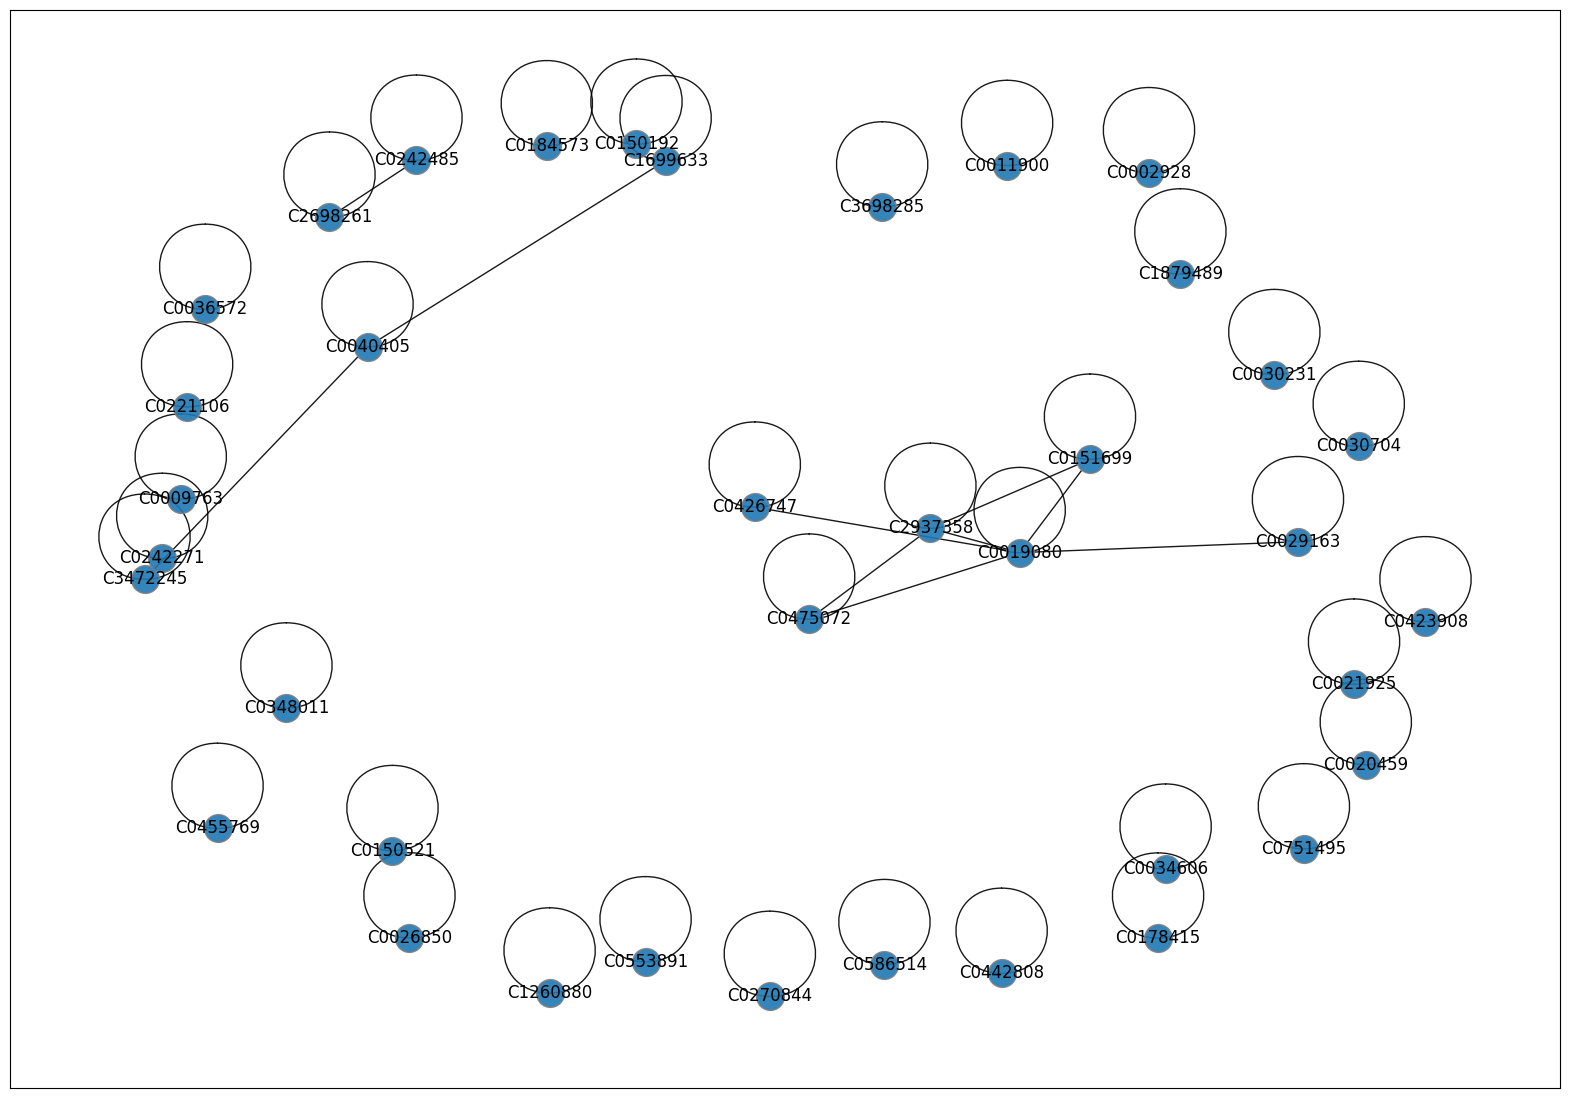

In [220]:
plt.figure(figsize=[20,14])
plt.tight_layout()
nx.draw_networkx(nx_g_kg, pos=pos_kg, arrows=True, with_labels=False, **options)
nx.draw_networkx_labels(nx_g_kg, pos_kg, gnidx_sample, font_size=12)

{0: Text(-0.17587009197583836, 0.8820589826378755, 'C0150521'),
 1: Text(-0.43105636627671845, 0.8806633273711845, 'C0348011'),
 2: Text(0.4996179487783897, -0.06113804072438791, 'C0242271'),
 3: Text(-0.5290396828568595, 0.5045954073659565, 'C0151699'),
 4: Text(-0.26799816600112486, 0.06456196239614566, 'C3698285'),
 5: Text(-0.8462551167807183, 0.09419097599314535, 'C0021925'),
 6: Text(-0.8174168297284099, 0.059218583340987674, 'C0036572'),
 7: Text(-0.6403584936145263, 0.7073315765480094, 'C0442808'),
 8: Text(-0.21882751511973655, 0.25270976964938263, 'C0242485'),
 9: Text(-0.0839531374419899, 0.28029126988779235, 'C1879489'),
 10: Text(0.7547848706232319, 0.19141627462779875, 'C0034606'),
 11: Text(-0.14671581699340835, -0.7926924324883384, 'C0221106'),
 12: Text(-0.22265954385130848, -0.13142667484774792, 'C0002928'),
 13: Text(0.6157139877940351, -0.39341078197524953, 'C1699633'),
 14: Text(-0.03867665044891463, -0.3748917038979587, 'C0020459'),
 15: Text(0.03665145282706452, 

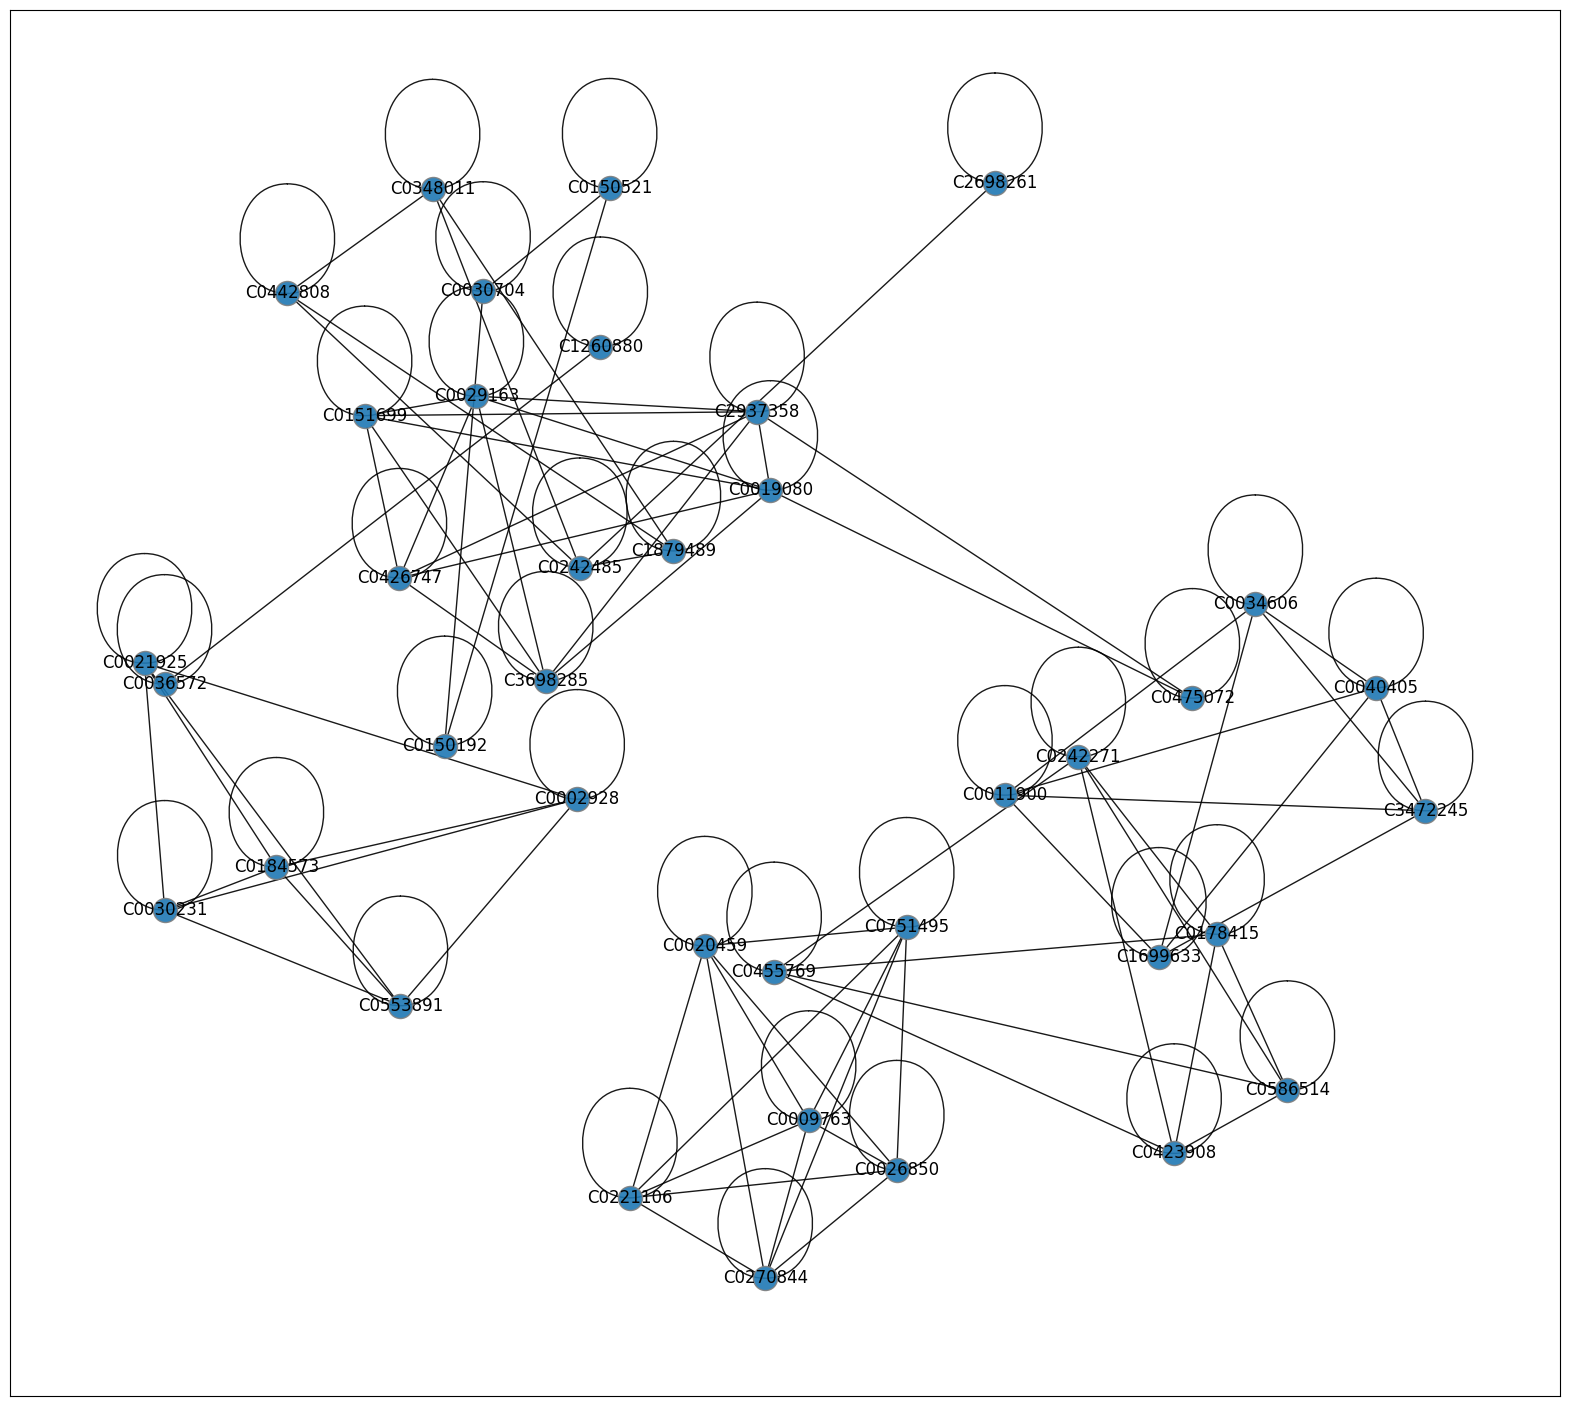

In [235]:
plt.figure(figsize=[20,18])
plt.tight_layout()
nx.draw_networkx(nx_g_kg_combo, pos=pos_kg_c, arrows=True, with_labels=False, **options)
nx.draw_networkx_labels(nx_g_kg_combo, pos_kg_c, gnidx_sample, font_size=12)